<a href="https://colab.research.google.com/github/EstebanLT/HPLC/blob/main/Chromatogram_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ICS-chromatograms" data-toc-modified-id="ICS-chromatograms-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ICS chromatograms</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Plots-1st-run" data-toc-modified-id="Plots-1st-run-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plots 1st run</a></span></li><li><span><a href="#Plots-2nd-run" data-toc-modified-id="Plots-2nd-run-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plots 2nd run</a></span></li><li><span><a href="#Plots-3rd-run" data-toc-modified-id="Plots-3rd-run-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plots 3rd run</a></span></li><li><span><a href="#Plots-4th-run" data-toc-modified-id="Plots-4th-run-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plots 4th run</a></span><ul class="toc-item"><li><span><a href="#Protein-4-vs-CelS2" data-toc-modified-id="Protein-4-vs-CelS2-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Protein 4 vs CelS2</a></span></li></ul></li><li><span><a href="#Plots-5th-run" data-toc-modified-id="Plots-5th-run-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Plots 5th run</a></span></li></ul></li><li><span><a href="#Rezex" data-toc-modified-id="Rezex-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Rezex</a></span></li><li><span><a href="#AEC-chromatograms" data-toc-modified-id="AEC-chromatograms-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>AEC chromatograms</a></span><ul class="toc-item"><li><span><a href="#AEC-protein-4" data-toc-modified-id="AEC-protein-4-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>AEC protein 4</a></span></li><li><span><a href="#AEC-protein-7" data-toc-modified-id="AEC-protein-7-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>AEC protein 7</a></span></li></ul></li><li><span><a href="#SEC-chromatogram" data-toc-modified-id="SEC-chromatogram-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SEC chromatogram</a></span></li></ul></div>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from matplotlib import gridspec


import unicodedata
plt.rcParams['font.family'] = 'Times'

sys.path.append('./Scripts/')
import esteban_biohelpers as eb
import esteban_helpers as eh

## ICS chromatograms

In [ ]:
# Path where all the exported chromatogram data is
path = '../03-Lab_work/Activity_assays/05-20220613-WT_4a_7/raw/'

# Get the list of txt which files in that folder
txts = [i for i in os.listdir(path) if '.txt' in i]

txts[5]

'Std_C1ox-0.00125_14.txt'

In [ ]:
# Check where the data starts in each file (previously seen to start after 'Chromatogram Data:\n')
# for t in txts:
#     filepath = os.path.join(path, t)
#     with open(filepath) as f:
#         lines = f.readlines()
#         print('{}: {}'.format(t, lines.index('Chromatogram Data:\n')))

In [ ]:
# lines[40:50]

Apparently, it's always line 41. And the units of the time column are min, and for value, they are nC

### Functions

In [ ]:
# make a function for translating all files to one dataframe
def get_run_df(path, skiprows=42, sort_cols=True, rezex=False, idx_inj=None, name_len=3):
    try:
        # Get the list of txt which files in that folder
        txts = [i for i in os.listdir(path) if '.txt' in i]
        # Reorder txts by how they were run
        # Reorder txts by how they were run
        if not idx_inj:
            if rezex:
                idx_inj = -1
            else:
                idx_inj = -3
        if idx_inj != 99:
            txts_dict = dict(zip([int(t.split('_')[idx_inj].replace('.txt', '')) for t in txts], txts))
        else:
            txts_dict = dict(zip(range(len(txts)), txts))
        keys = list(txts_dict.keys())
        keys.sort()
        txts = [txts_dict[k] for k in keys]
        # Read the contents of all files
        df = pd.DataFrame(columns=['time'])
        for t in txts:
            filepath = os.path.join(path, t)
            # get sample name
            sname = '_'.join(t.split('_')[:name_len])
            # read the new file data
            new_df = pd.read_csv(filepath, sep='\t', decimal=',', skiprows=skiprows, header=0, 
                            names=['time', 'step', 'value'], usecols=['time', 'value'], encoding='utf-8'
                           )
            # Fix the weird characters in the value column
            if new_df.value.dtype is not np.dtype("float64"):
                new_df['value'] = new_df.value.apply(
                    lambda x: unicodedata.normalize('NFKD', x)\
                    .replace(',', '.').replace(' ', '')).astype(np.float64)
            # Subtract the first time to all
            new_df['time'] = (new_df.time - new_df.time[0]).round(4)
            # rename the column "value" with the sample's name
            new_df.rename(columns={'value': sname}, inplace=True)
            df = pd.merge(left=df, right=new_df, how='outer', on='time', sort=True)
        if '_01_ED' in df:
            df = df.drop('_01_ED', axis=1).dropna()
        if sort_cols:
            cols = df.columns.to_list()[1:]
            cols.sort()
            df = df[['time'] + cols]
                
        return df
    except Exception as e:
        print('Error: {}, file{}'.format(e, t))
        

In [ ]:
def plot_ics_chrom(df, cols, x_min=0, x_max=12, y_min=None, y_max=None, ax=None, log_y=False, shifty=0, shiftx=0, name_len=2, figsize=(8,3), dpi=300, no_negatives=False, ylabel='Charge (nC)', style='-', color=None, unlabel=False, labels_ontop=True, labshift=5, nwlabs=None):
#     try:
    plt.figure(figsize=figsize, dpi=dpi)
    if ax is None:
        ax = plt.axes()
    if 'time' in df:
        x = df.time
    else:
        x = df.index.to_series()
    x_min = max(x_min, x.min())
    x_max = min(x_max, x.max())
    if isinstance(shiftx, dict):
        x_min += min(shiftx.values())
        x_max += max(shiftx.values())
        print('shftx is dict, lims: {}, {}'.format(x_min, x_max))
    else:
        x_min += shiftx
        x_max += shiftx

    df = df[x.between(x_min, x_max)]
    if log_y or no_negatives:
        df[df<0] = 0.0
    y_shift = 0
    x_shift = 0
    c = color
    for col in cols:
        if nwlabs:
            label = nwlabs[col]
        else:
            label = ' '.join(col.split('_')[:name_len])
        if unlabel:
            label=None
        #label = col
        if isinstance(shifty, dict):
            y_shift = shifty[col]
        if isinstance(shiftx, dict):
            x_shift = shiftx[col]
            print('sample: {}  shiftx: {}'.format(col, x_shift))
        if isinstance(color, dict):
            c = color[col]
        sns.lineplot(x=x+x_shift, y=df[col]+y_shift, ax=ax, label=label, linestyle=style,
                     color=c
                    )
        if shifty and labels_ontop:
            plt.text(x_max, y_shift+labshift, label, va='bottom', ha='right')

        if not isinstance(shiftx, dict):
            x_shift += shiftx
        if not isinstance(shifty, dict):
            y_shift += shifty

    ax.legend(frameon=False)
    if isinstance(shifty, dict) or shifty>0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], frameon=False)
    if y_min is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(y_min, ylims[1])
    if y_max is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(ylims[0], y_max)
    #     ax.set_ylim(y_range[0], y_range[1])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel(ylabel)
    if log_y:
        ax.set_yscale('log')
    sns.despine(left=True)
    if shifty and labels_ontop:
        ax.legend().remove()
    return ax
#     except Exception as e:
#         print('Error: {}'.format(e))
#         print('Sample: {}'.format(col))

### Plots 1st run

In [ ]:
path = '../03-Lab_work/Activity_assays/01-220427-Mutants_amanda_3_substrates/Chrom/'
df_1 = get_run_df(path).set_index('time')

In [ ]:
[c for c in df_1 if '24' in c]

['T24h_Avi_2a',
 'T24h_Avi_2b',
 'T24h_Avi_3a',
 'T24h_Avi_3b',
 'T24h_Avi_4a',
 'T24h_Avi_4b',
 'T24h_Avi_C-NE',
 'T24h_Avi_CelS2',
 'T24h_Avi_WT',
 'T24h_BMCC_2a',
 'T24h_BMCC_2b',
 'T24h_BMCC_3a',
 'T24h_BMCC_3b',
 'T24h_BMCC_4a',
 'T24h_BMCC_4b',
 'T24h_BMCC_C-NE',
 'T24h_BMCC_CelS2',
 'T24h_BMCC_WT',
 'T24h_PASC_2a',
 'T24h_PASC_2b',
 'T24h_PASC_3a',
 'T24h_PASC_3b',
 'T24h_PASC_4a',
 'T24h_PASC_4b',
 'T24h_PASC_C-NE',
 'T24h_PASC_CelS2',
 'T24h_PASC_WT']

In [ ]:
df_1.columns.to_list()

['1h_Avi_WT',
 '1h_PASC_WT',
 'Blank_01_ED',
 'Blank_02_ED',
 'Blank_03_ED',
 'Blank_04_ED',
 'Blank_11_ED',
 'EG_Avi_2a',
 'EG_Avi_2b',
 'EG_Avi_3a',
 'EG_Avi_3b',
 'EG_Avi_4a',
 'EG_Avi_4b',
 'EG_Avi_C-NE',
 'EG_Avi_CelS2',
 'EG_Avi_WT',
 'EG_BMCC_2a',
 'EG_BMCC_2b',
 'EG_BMCC_3a',
 'EG_BMCC_3b',
 'EG_BMCC_4a',
 'EG_BMCC_4b',
 'EG_BMCC_C-NE',
 'EG_BMCC_CelS2',
 'EG_BMCC_WT',
 'EG_PASC_2a',
 'EG_PASC_2b',
 'EG_PASC_3a',
 'EG_PASC_3b',
 'EG_PASC_4a',
 'EG_PASC_4b',
 'EG_PASC_C-NE',
 'EG_PASC_CelS2',
 'EG_PASC_WT',
 'Std_C1ox_0,0025',
 'Std_C1ox_0,0025_x',
 'Std_C1ox_0,0025_y',
 'Std_C1ox_0,01',
 'Std_C1ox_0,01_x',
 'Std_C1ox_0,01_y',
 'T24h_Avi_2a',
 'T24h_Avi_2b',
 'T24h_Avi_3a',
 'T24h_Avi_3b',
 'T24h_Avi_4a',
 'T24h_Avi_4b',
 'T24h_Avi_C-NE',
 'T24h_Avi_CelS2',
 'T24h_Avi_WT',
 'T24h_BMCC_2a',
 'T24h_BMCC_2b',
 'T24h_BMCC_3a',
 'T24h_BMCC_3b',
 'T24h_BMCC_4a',
 'T24h_BMCC_4b',
 'T24h_BMCC_C-NE',
 'T24h_BMCC_CelS2',
 'T24h_BMCC_WT',
 'T24h_PASC_2a',
 'T24h_PASC_2b',
 'T24h_PASC_3a',


<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

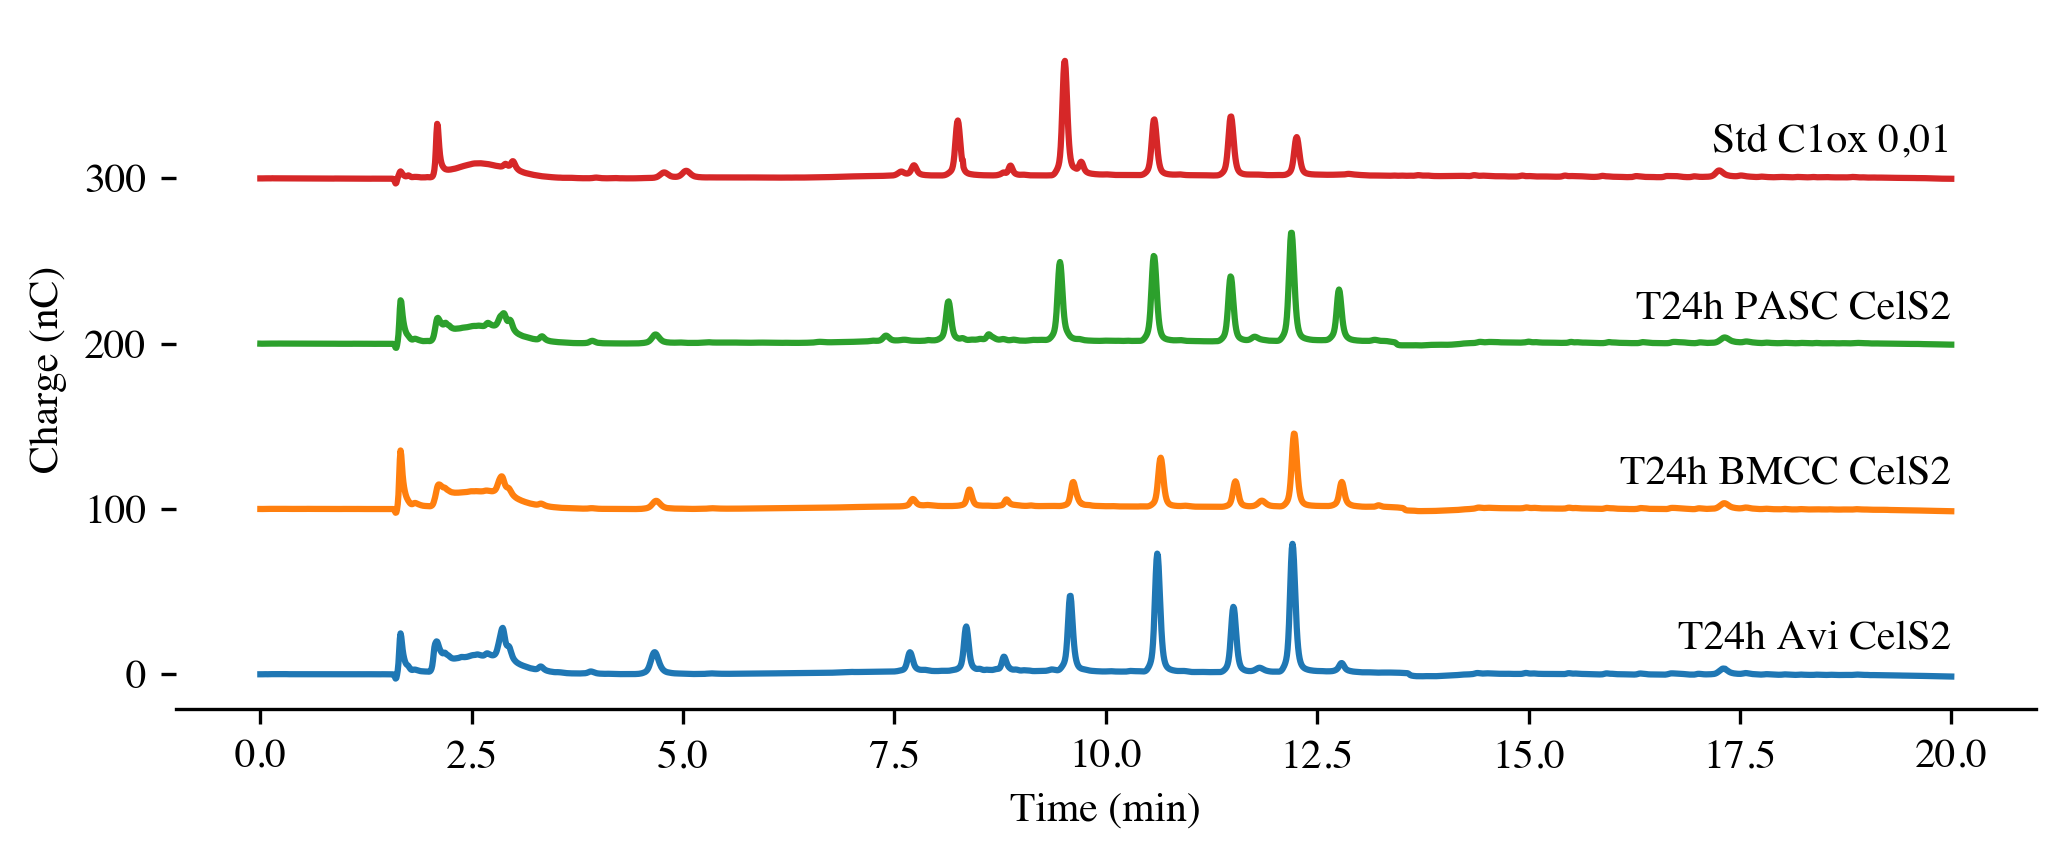

In [ ]:
sns.set_palette('tab10')
cols = [c for c in df_1 if '24' in c and 'CelS2' in c] + [ 'Std_C1ox_0,01_x']
colors = dict(zip(cols, sns.color_palette()))
plot_ics_chrom(df_1, cols, name_len=3, shifty=100, x_min=0, x_max=20, color=colors)

In [ ]:
cols

['T24h_Avi_2a',
 'T24h_Avi_2b',
 'T24h_Avi_3a',
 'T24h_Avi_3b',
 'T24h_Avi_4a',
 'T24h_Avi_4b',
 'T24h_Avi_C-NE',
 'T24h_Avi_CelS2',
 'T24h_Avi_WT',
 'Std_C1ox_0,01_x']

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

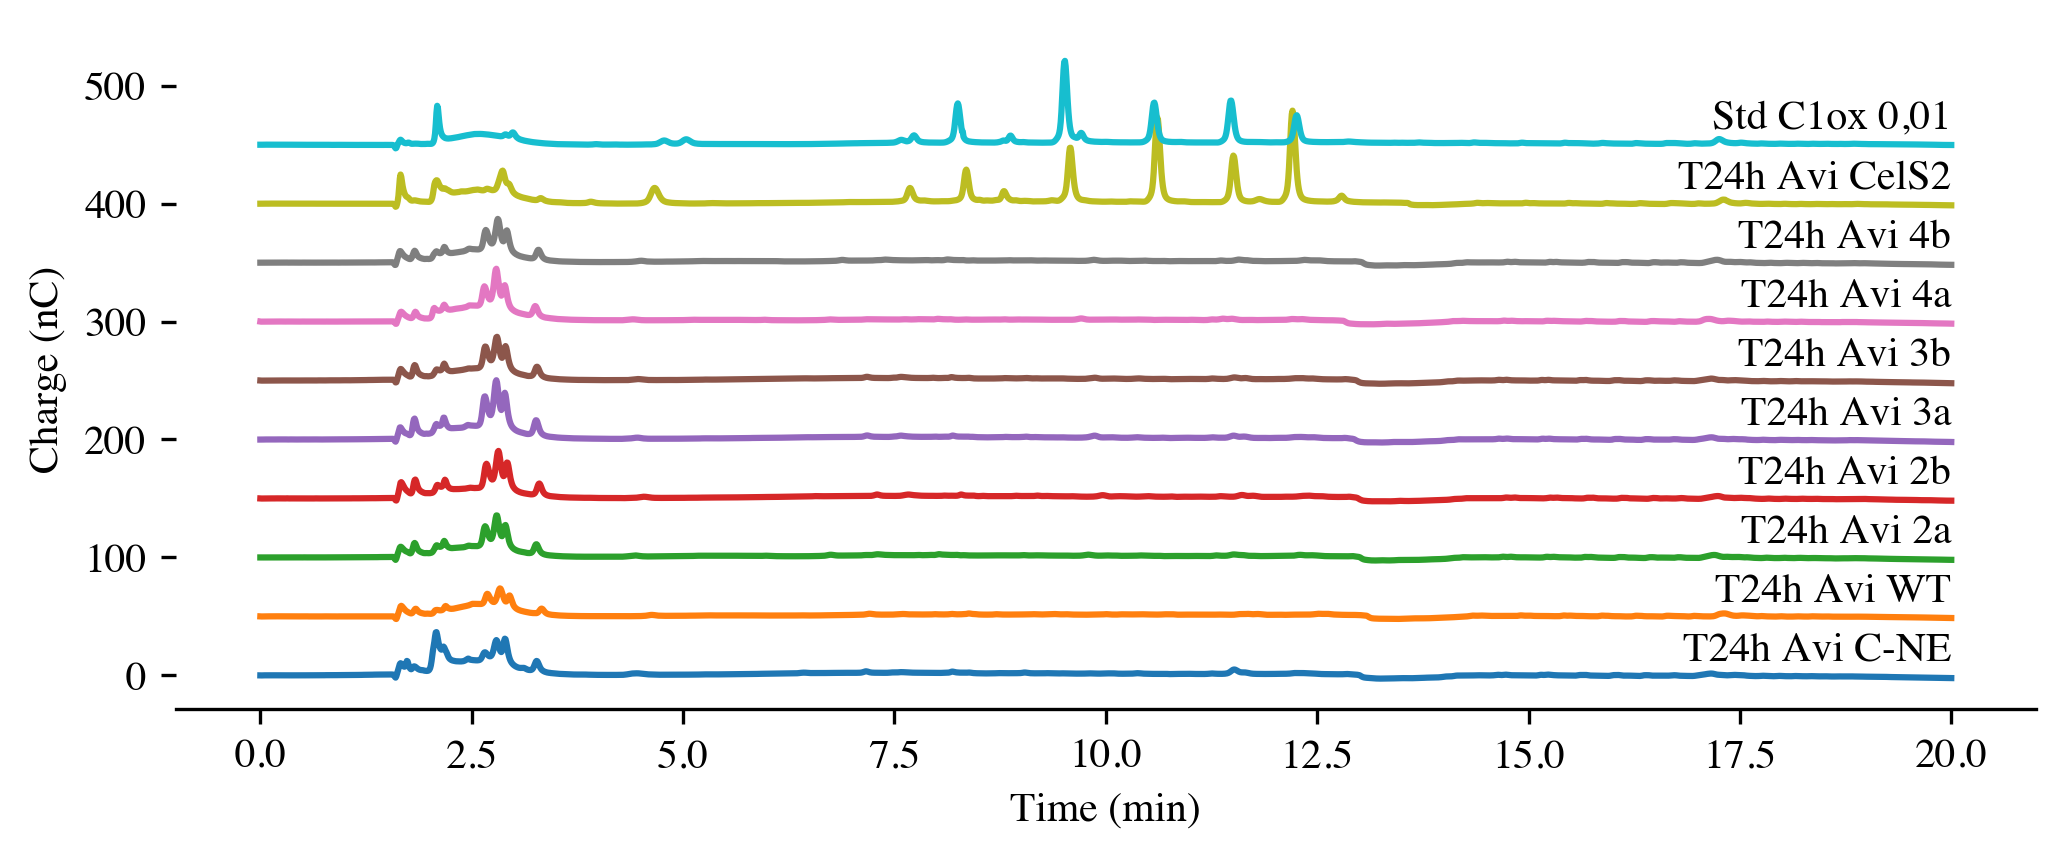

In [ ]:

# cols = [c for c in df_1 if '24' in c and 'Avi' in c] + [ 'Std_C1ox_0,01_x']
cols = [
 'T24h_Avi_C-NE',
 'T24h_Avi_WT',
    'T24h_Avi_2a',
 'T24h_Avi_2b',
 'T24h_Avi_3a',
 'T24h_Avi_3b',
 'T24h_Avi_4a',
 'T24h_Avi_4b',
 'T24h_Avi_CelS2',
 'Std_C1ox_0,01_x'
]
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
plot_ics_chrom(df_1, cols, name_len=3, shifty=50, x_min=0, x_max=20, color=colors)

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

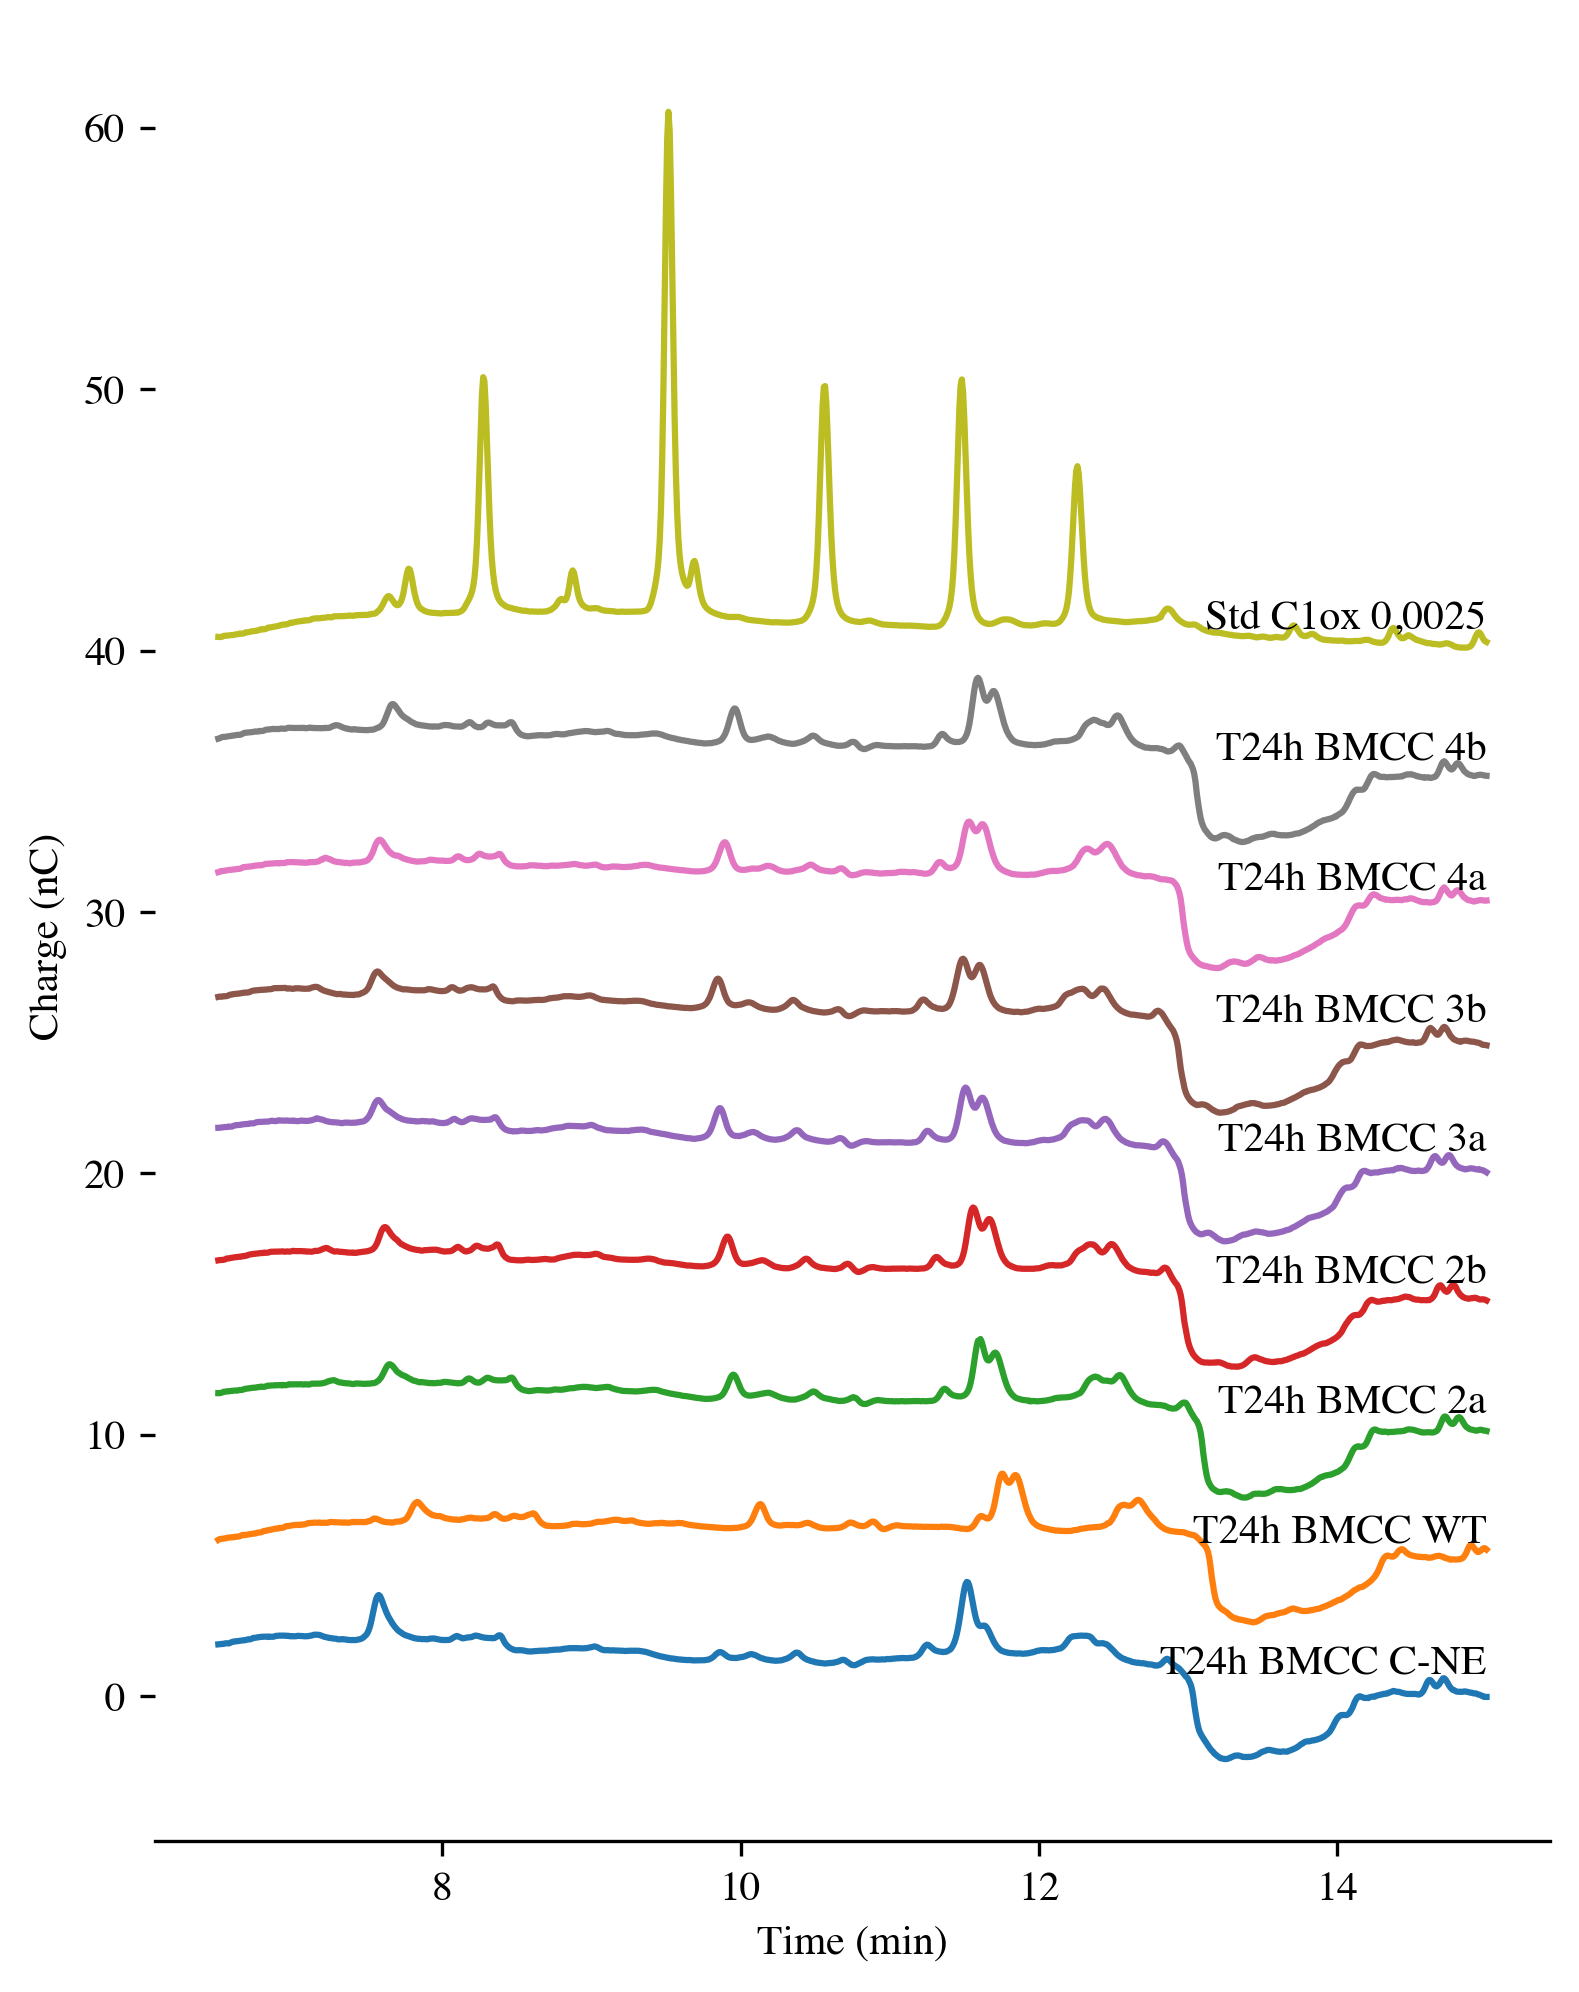

In [ ]:

# cols = [c for c in df_1 if '24' in c and 'BMCC' in c] + [ 'Std_C1ox_0,01_x']
cols = [
 'T24h_BMCC_C-NE',
 'T24h_BMCC_WT',
    'T24h_BMCC_2a',
 'T24h_BMCC_2b',
 'T24h_BMCC_3a',
 'T24h_BMCC_3b',
 'T24h_BMCC_4a',
 'T24h_BMCC_4b',
#  'T24h_BMCC_CelS2',
 'Std_C1ox_0,0025_x'
]
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
plot_ics_chrom(df_1, cols, name_len=3, shifty=5, x_min=6.5, x_max=15, color=colors, figsize=(6,8), labshift=0.5)

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

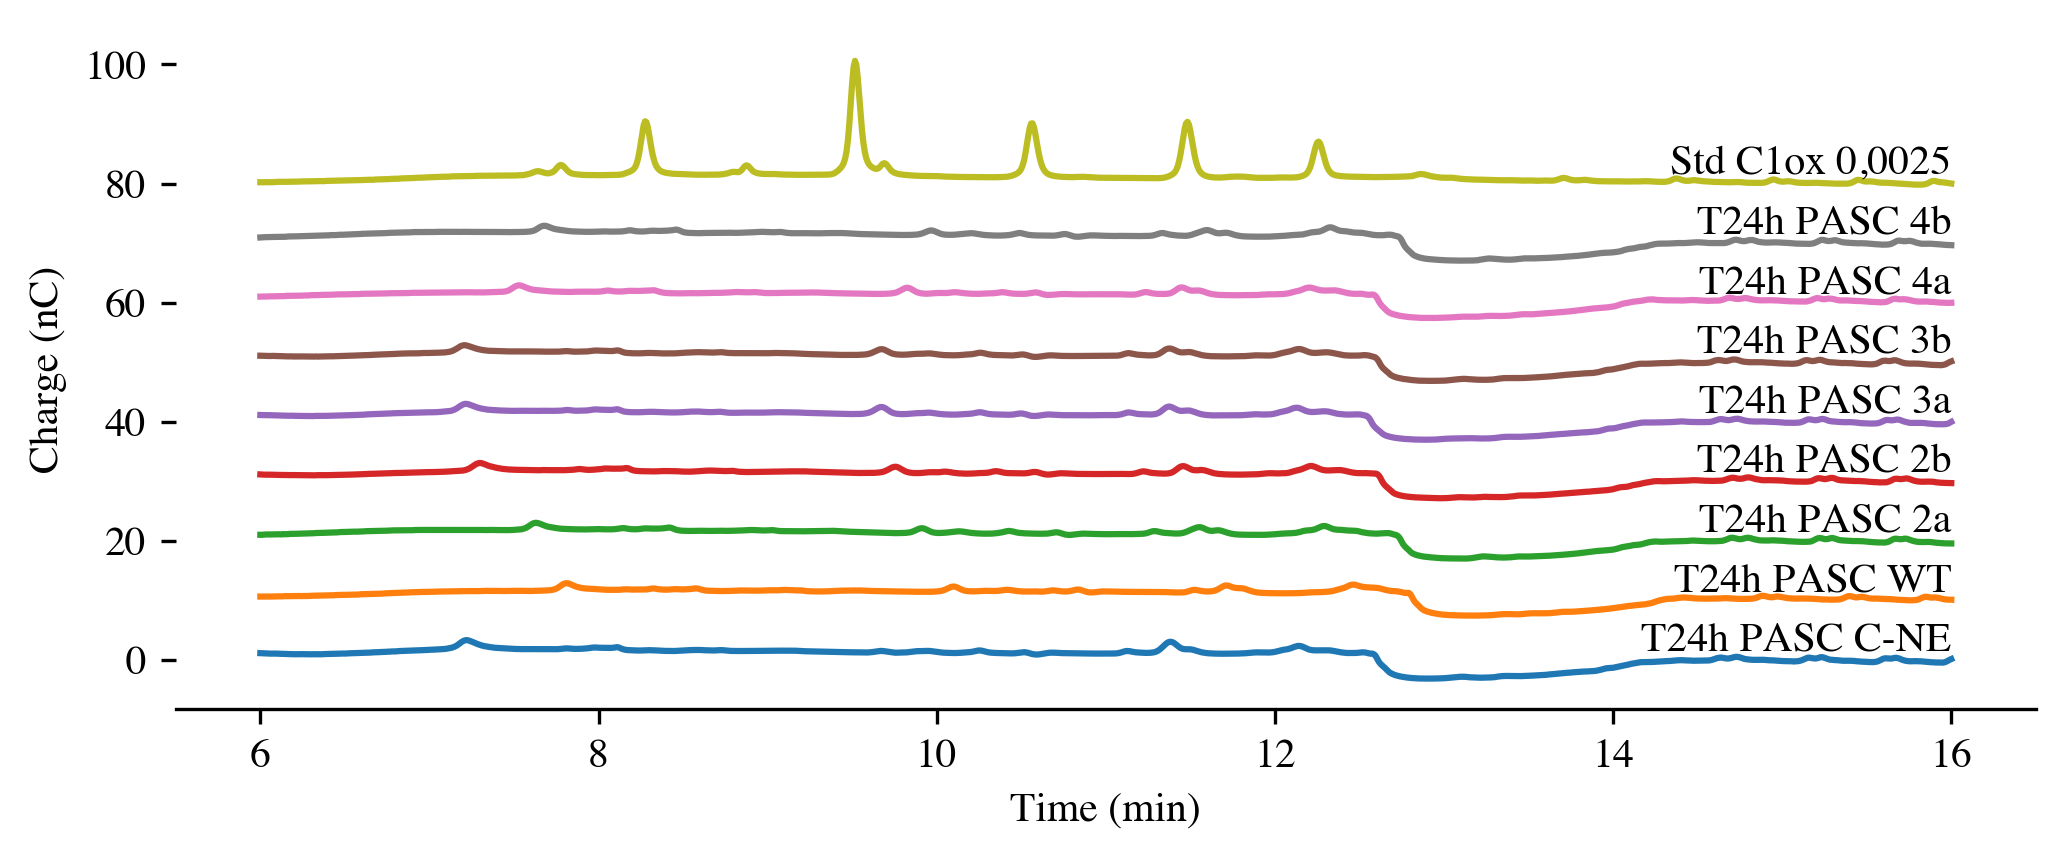

In [ ]:

# cols = [c for c in df_1 if '24' in c and 'Avi' in c] + [ 'Std_C1ox_0,01_x']
cols = [
 'T24h_PASC_C-NE',
 'T24h_PASC_WT',
    'T24h_PASC_2a',
 'T24h_PASC_2b',
 'T24h_PASC_3a',
 'T24h_PASC_3b',
 'T24h_PASC_4a',
 'T24h_PASC_4b',
#  'T24h_Avi_CelS2',
#  'Std_C1ox_0,01_x'
 'Std_C1ox_0,0025_x'
]
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
plot_ics_chrom(df_1, cols, name_len=3, shifty=10, x_min=6, x_max=16, color=colors, labshift=0.1)

### Plots 2nd run

In [ ]:
# Path where all the exported chromatogram data is
path = '../03-Lab_work/Activity_assays/02-220509-Mutants_amanda_4a_2a_wt_EG/Chrom/'
df = get_run_df(path)

[]

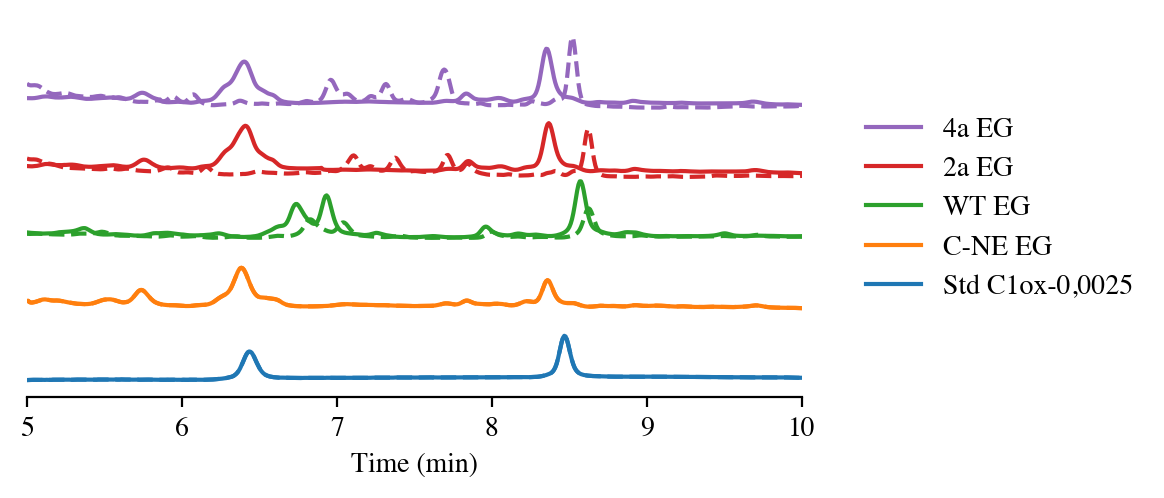

<Figure size 2400x900 with 0 Axes>

In [ ]:
cols = [c for c in df if '0,01_x' in c]+[c for c in df if 'EG_1' in c]
cols = [
    'Std_C1ox-0,0025_1',
    'C-NE_EG_1', 
    'WT_EG_1', 
    '2a_EG_1',
    '4a_EG_1',
#     'CelS2_EG_1', 
]
colors = dict(zip(cols, sns.color_palette()[:len(cols)]))
shiftx = dict(zip(cols, [-.06, 0.03, -0.18,0.01, 0.02, 0]))

#cols = [c for c in df if 'WT' in c]
# Make a plot
ax = plot_ics_chrom(
    df, cols, 
    log_y=False, 
    x_min=5, x_max=10.5,
    #y_max=530,
    shifty=12,
#     shiftx=shiftx,
    name_len=2,
    figsize=(5, 2.5), dpi=200, color=colors
)

# plt.title('Insoluble fraction')

cols_2 = [
    'Std_C1ox-0,0025_1',
    'C-NE_EG_1', 
    'WT_EG_NA', 
    '2a_EG_NA',
    '4a_EG_NA',
#     'CelS2_EG_NA', 
]
colors = dict(zip(cols_2, sns.color_palette()[:len(cols_2)]))
shiftx = dict(zip(cols_2, [-.06, 0.03,  -0.18,0.01, 0.02, 0]))

plot_ics_chrom(
    df, cols_2, 
    log_y=False, 
    x_min=5, x_max=10.5,
    #y_max=530,
    shifty=12,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(5, 3.5), dpi=100,
    ax=ax, style='--', color=colors, unlabel=True
)
ax.set_xlim(5, 10)
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])

[]

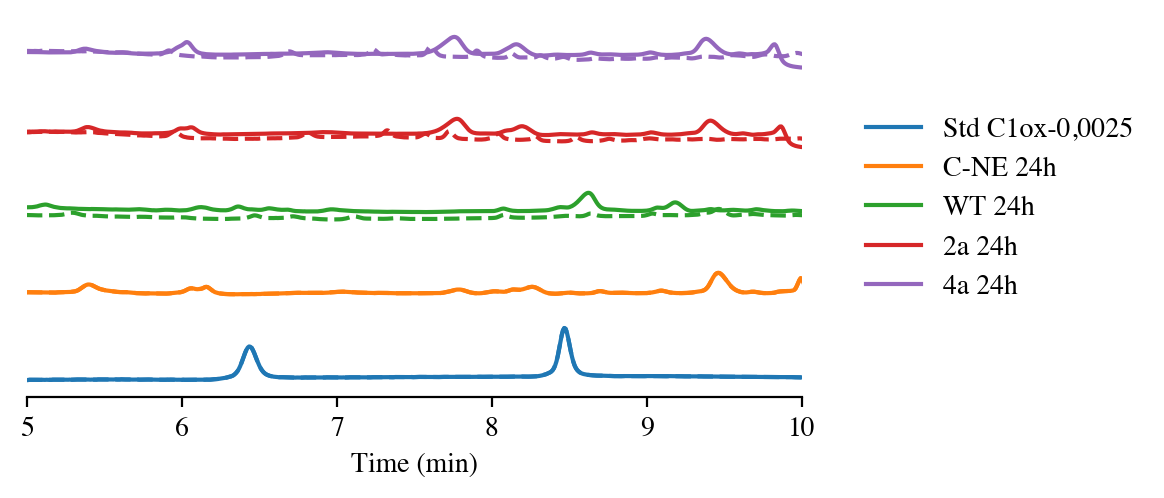

<Figure size 2400x900 with 0 Axes>

In [ ]:
cols = [c for c in df if '0,01_x' in c]+[c for c in df if '24h_1' in c]
cols = [
    'Std_C1ox-0,0025_1',
    'C-NE_24h_1', 
    'WT_24h_1', 
    '2a_24h_1',
    '4a_24h_1',
#     'CelS2_24h_1', 
]
colors = dict(zip(cols, sns.color_palette()[:len(cols)]))
shiftx = dict(zip(cols, [-.06, 0.03, -0.18,0.01, 0.02, 0]))

#cols = [c for c in df if 'WT' in c]
# Make a plot
ax = plot_ics_chrom(
    df, cols, 
    log_y=False, 
    x_min=5, x_max=10.5,
    #y_max=530,
    shifty=12,
#     shiftx=shiftx,
    name_len=2,
    figsize=(5, 2.5), dpi=200, color=colors
)

# plt.title('Insoluble fraction')

cols_2 = [
    'Std_C1ox-0,0025_1',
    'C-NE_24h_1', 
    'WT_24h_NA', 
    '2a_24h_NA',
    '4a_24h_NA',
#     'CelS2_24h_NA', 
]
colors = dict(zip(cols_2, sns.color_palette()[:len(cols_2)]))
shiftx = dict(zip(cols_2, [-.06, 0.03,  -0.18,0.01, 0.02, 0]))

plot_ics_chrom(
    df, cols_2, 
    log_y=False, 
    x_min=5, x_max=10.5,
    #y_max=530,
    shifty=12,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(5, 3.5), dpi=100,
    ax=ax, style='--', color=colors, unlabel=True
)
ax.set_xlim(5, 10)
ax.legend(bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])

Text(0.5, 1.0, 'Soluble fraction')

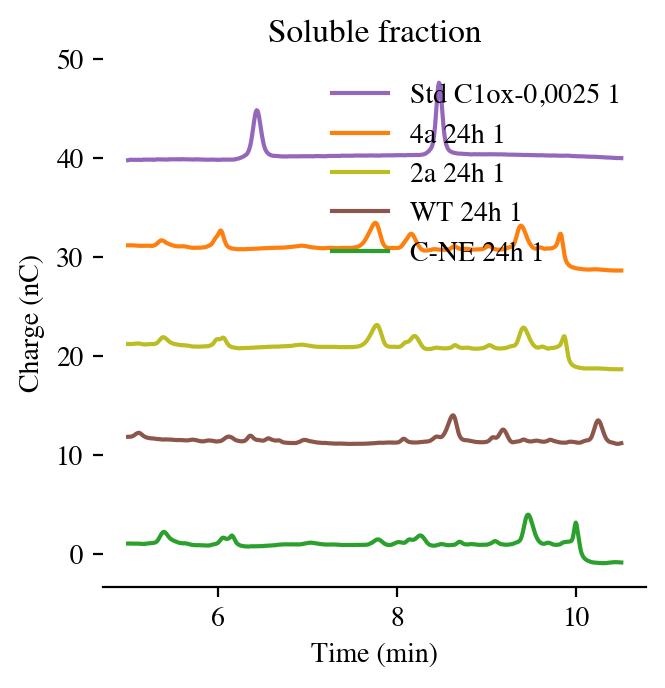

In [ ]:
cols = [c for c in df if '0,01_x' in c]+[c for c in df if 'EG_1' in c]
cols = [
    'C-NE_24h_1', 
    'WT_24h_1', 
    '2a_24h_1',
    '4a_24h_1',
    'Std_C1ox-0,0025_1',
#     'CelS2_24h_1', 
]

# Make a plot
ax = plot_ics_chrom(
    df, cols, 
    log_y=False, 
    x_min=5, x_max=10.5,
    #y_max=530,
    shifty=10,
    name_len=3,
    figsize=(3.5, 3.5), dpi=200
)
# ax.legend().remove()
plt.title('Soluble fraction')

In [ ]:
def align_max_range(col, xmin=5, xmax=7):
    # subset between the desired reference range
    coli = col[col.index.to_series().between(xmin,xmax)]
    tmax = coli.idxmax()
#     time_max = dfi.loc[dfi[col] == maxi, 'time'].iloc[0]

    col.index = col.index - tmax + np.average([xmin, xmax])
    #df = df[df.index >= 0].reset_index(drop=True)
    
    return col

In [ ]:
dfi = df.copy().set_index('time')

In [ ]:
dfii = pd.DataFrame()
for c in dfi:
    dfii = dfii.join(align_max_range(dfi[c]), how='outer')
dfii['time'] = dfii.index

In [ ]:
dfii

2a_0h_1       2a_0h_2  2a_0h_3  2a_1h_1  2a_1h_2  2a_1h_3  2a_24h_1  \
time                                                                            
-1.0000       NaN           NaN      NaN      NaN      NaN      NaN       NaN   
-0.9917       NaN           NaN      NaN      NaN      NaN      NaN       NaN   
-0.9833       NaN           NaN      NaN      NaN      NaN      NaN       NaN   
-0.9750       NaN           NaN      NaN      NaN      NaN      NaN       NaN   
-0.9667       NaN           NaN      NaN      NaN      NaN      NaN       NaN   
...           ...           ...      ...      ...      ...      ...       ...   
 26.9750      NaN  14603.707418      0.0  0.14780      NaN      NaN       NaN   
 26.9833      NaN  14603.707418      0.0  0.14990      NaN      NaN       NaN   
 26.9834      NaN           NaN      NaN      NaN      NaN      NaN       NaN   
 26.9917      NaN  14603.707418      0.0  0.15030      NaN      NaN       NaN   
 27.0000      NaN  14603.707418      0.0  0.15435      NaN      NaN       NaN   

          2a_24h_2  2a_24h_3  2a_24h_NA  ...  WT_24h_3  WT_24h_NA  WT_4h_1  \
time                                     ...                                 
-1.0000        NaN       NaN        NaN  ...       NaN        NaN      NaN   
-0.9917        NaN       NaN        NaN  ...       NaN        NaN      NaN   
-0.9833        NaN       NaN        NaN  ...       NaN        NaN      NaN   
-0.9750        NaN       NaN        NaN  ...       NaN        NaN      NaN   
-0.9667        NaN       NaN        NaN  ...       NaN        NaN      NaN   
...            ...       ...        ...  ...       ...        ...      ...   
 26.9750       NaN       NaN        NaN  ...       NaN        NaN      NaN   
 26.9833       NaN       NaN        NaN  ...       NaN        NaN      NaN   
 26.9834       NaN       NaN        NaN  ...       NaN        NaN      NaN   
 26.9917       NaN       NaN        NaN  ...       NaN        NaN      NaN   
 27.0000       NaN       NaN        NaN  ...       NaN        NaN      NaN   

          WT_4h_2  WT_4h_3  WT_EG_1  WT_EG_2  WT_EG_3  WT_EG_NA     time  
time                                                                      
-1.0000       NaN      NaN      NaN      NaN -0.06075       NaN  -1.0000  
-0.9917       NaN      NaN      NaN      NaN -0.09875       NaN  -0.9917  
-0.9833       NaN      NaN      NaN      NaN -0.09955       NaN  -0.9833  
-0.9750       NaN      NaN      NaN      NaN -0.09090       NaN  -0.9750  
-0.9667       NaN      NaN      NaN      NaN -0.08470       NaN  -0.9667  
...           ...      ...      ...      ...      ...       ...      ...  
 26.9750      NaN      NaN      NaN      NaN      NaN       NaN  26.9750  
 26.9833      NaN      NaN      NaN      NaN      NaN       NaN  26.9833  
 26.9834      NaN      NaN      NaN      NaN      NaN       NaN  26.9834  
 26.9917      NaN      NaN      NaN      NaN      NaN       NaN  26.9917  
 27.0000      NaN      NaN      NaN      NaN      NaN       NaN  27.0000  

[10866 rows x 96 columns]

In [ ]:
cols = [
     'CelS2_24h_NA',
#      'CelS2_EG_NA',
    'CelS2_0h_1',
 'CelS2_0h_2',
 'CelS2_0h_3',
 'CelS2_1h_1',
 'CelS2_1h_2',
 'CelS2_1h_3',
 'CelS2_4h_1',
 'CelS2_4h_2',
 'CelS2_4h_3',
 'CelS2_24h_1',
 'CelS2_24h_2',
 'CelS2_24h_3',
#  'CelS2_EG_1',
#  'CelS2_EG_2',
#  'CelS2_EG_3',
]


<AxesSubplot:xlabel='Time (min)', ylabel='Value (nC)'>

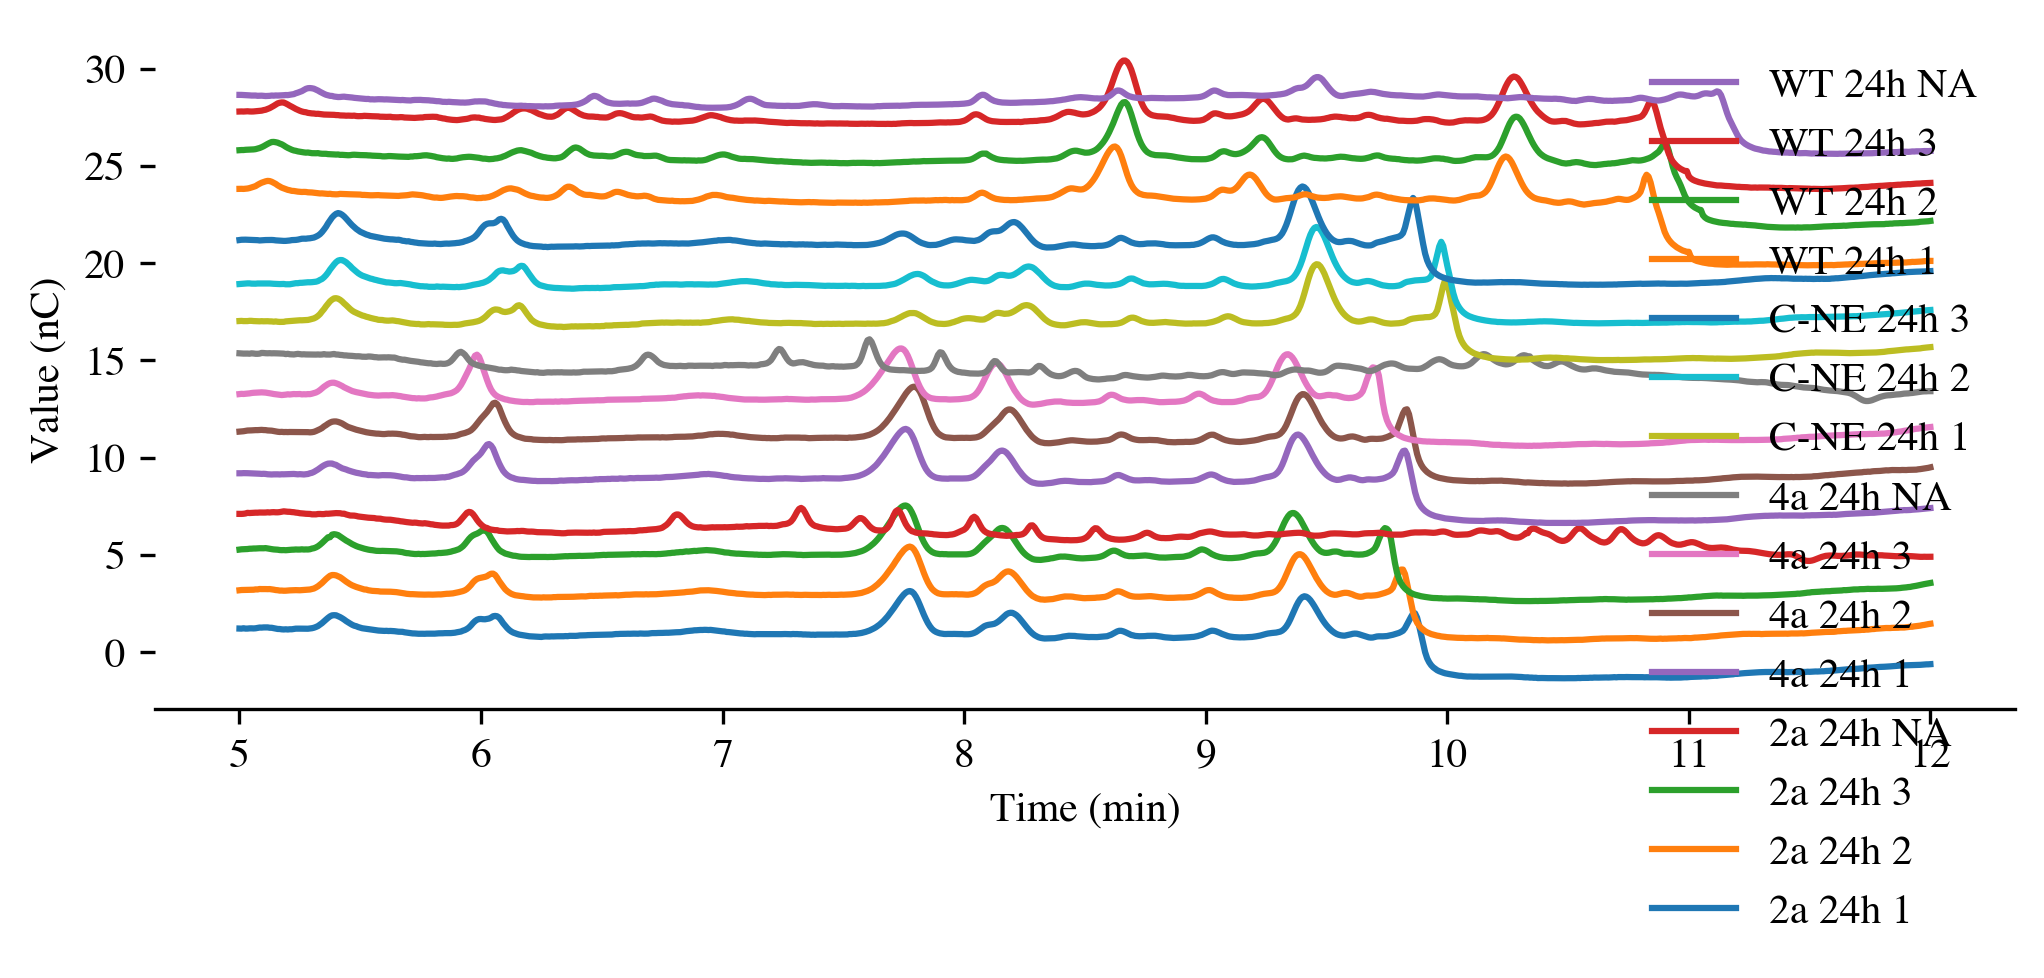

In [ ]:
plot_ics_chrom(df, [c for c in dfi if '24' in c and 'CelS2' not in c], shifty= 2, name_len=3)

In [ ]:
col = 'CelS2_24h_1'
align_max_range(dfi, col, xmin=5, xmax=7)

0      -0.05280
1      -0.04965
2      -0.05285
3      -0.04430
4      -0.04185
         ...   
3115   -0.01860
3116   -0.02140
3117   -0.01460
3118   -0.01695
3119   -0.00260
Name: CelS2_24h_1, Length: 3120, dtype: float64

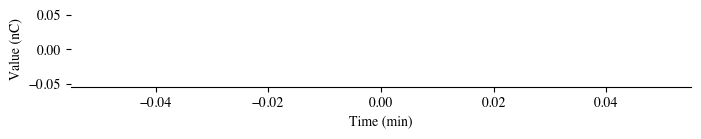

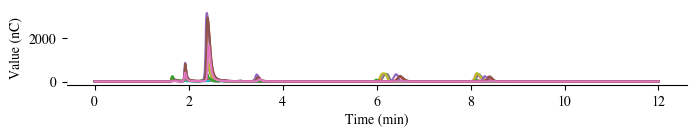

In [ ]:
for c in [x for x in df if 'CelS2' in x]:
    dfi[c] = align_max_range(dfi, c)
    
ax = plot_ics_chrom(dfi, [x for x in df if 'CelS2' in x], figsize=(8,1), dpi=100, name_len=3, x_min=0)
ax.legend([], frameon=False)
ax = plot_ics_chrom(df, [x for x in df if 'CelS2' in x], figsize=(8,1), dpi=100, name_len=3, x_min=0)
ax.legend([], frameon=False)
#plt.close('all')


/var/folders/w3/b3q1cq_x7q35bkr5nzyxm7wc0000gn/T/ipykernel_2207/544121493.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize, dpi=dpi)


Error: Data must be 1-dimensional
Sample: Std_B_C1ox_x
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_x
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_x
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_x
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_y
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_y
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_y
Error: Data must be 1-dimensional
Sample: Std_B_C1ox_y


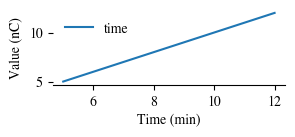

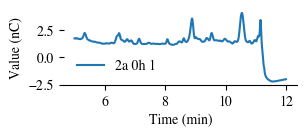

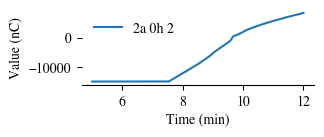

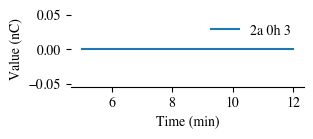

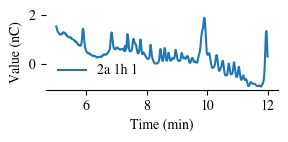

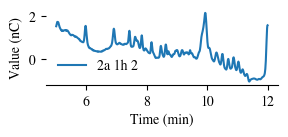

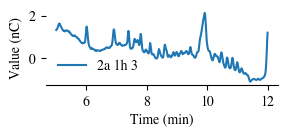

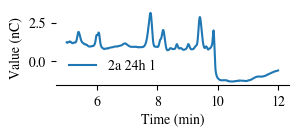

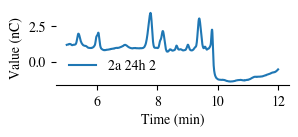

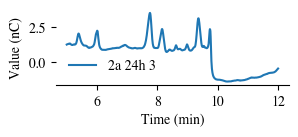

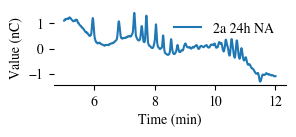

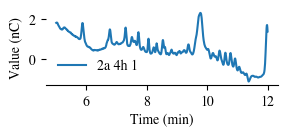

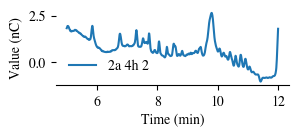

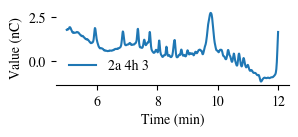

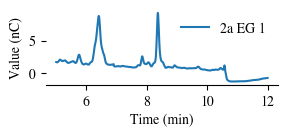

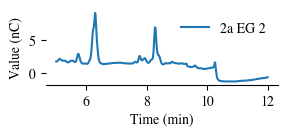

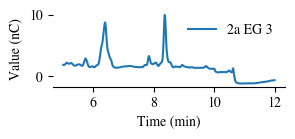

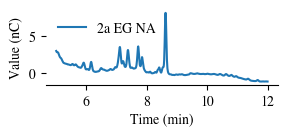

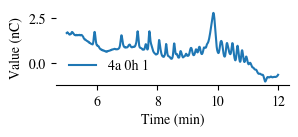

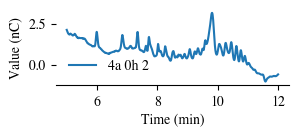

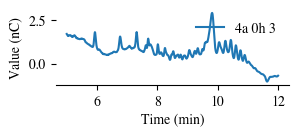

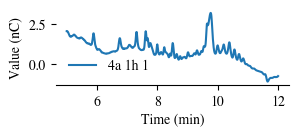

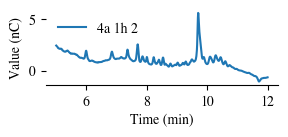

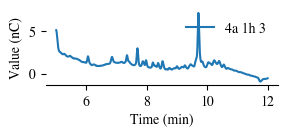

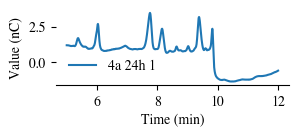

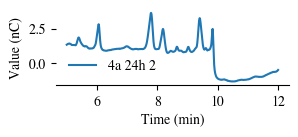

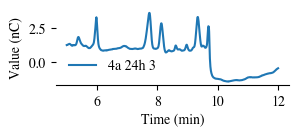

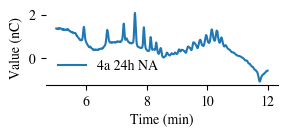

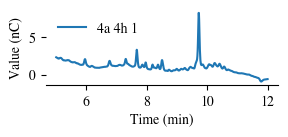

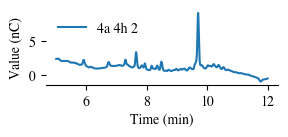

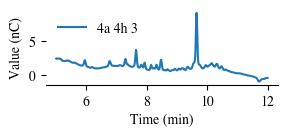

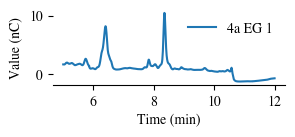

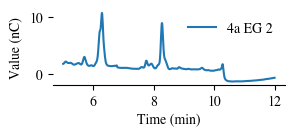

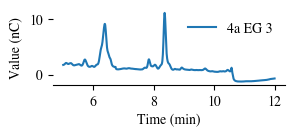

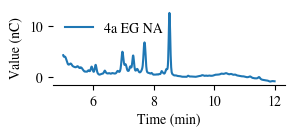

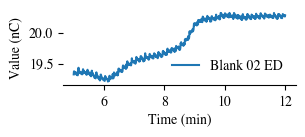

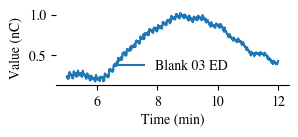

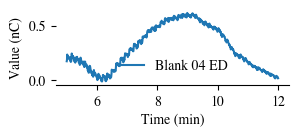

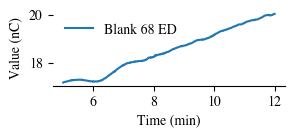

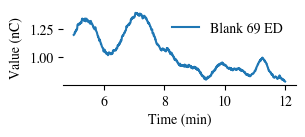

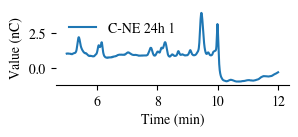

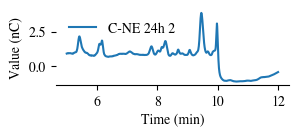

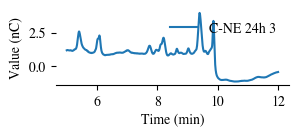

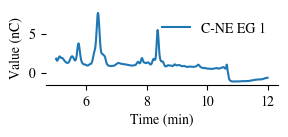

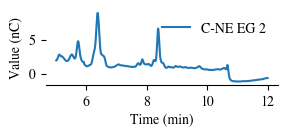

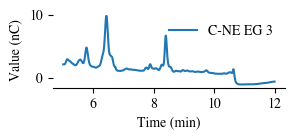

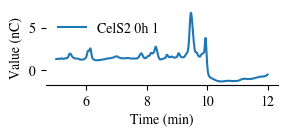

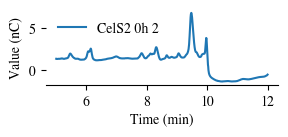

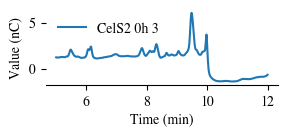

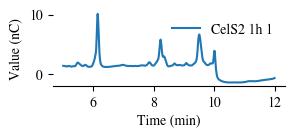

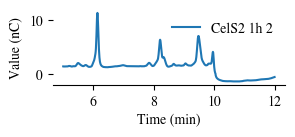

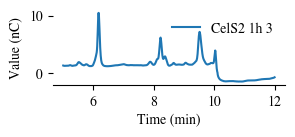

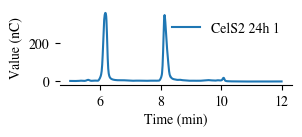

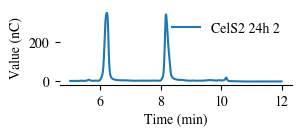

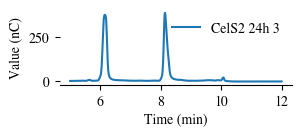

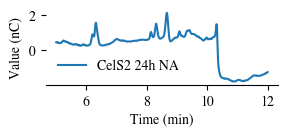

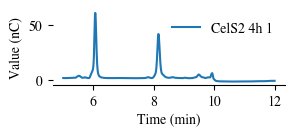

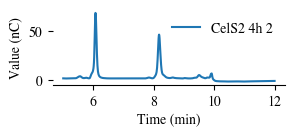

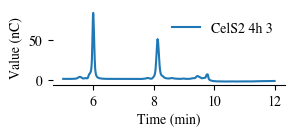

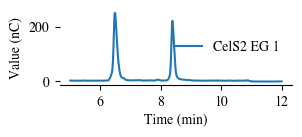

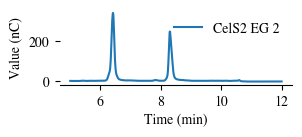

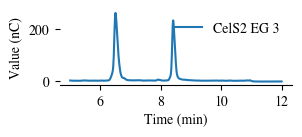

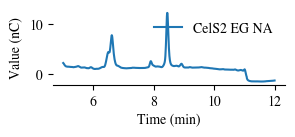

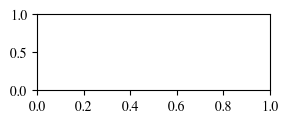

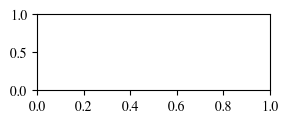

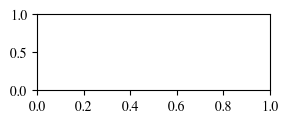

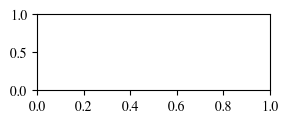

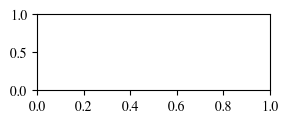

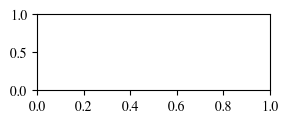

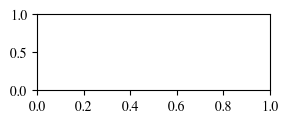

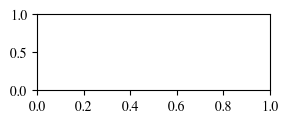

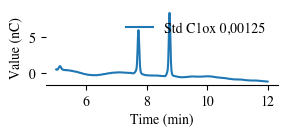

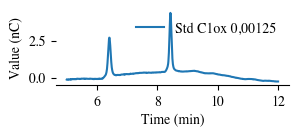

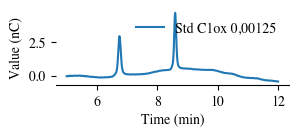

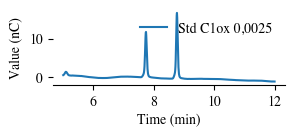

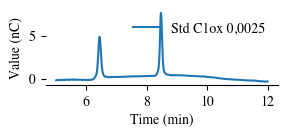

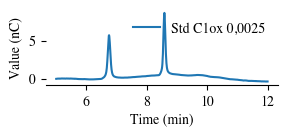

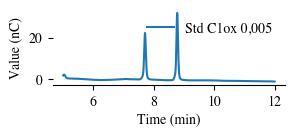

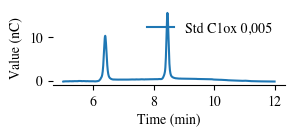

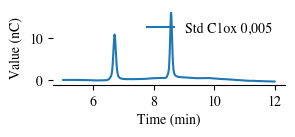

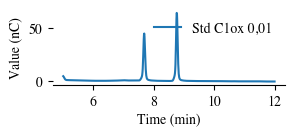

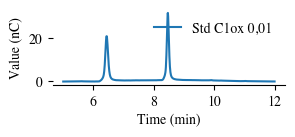

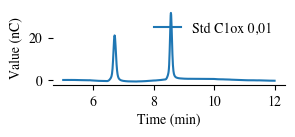

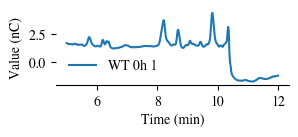

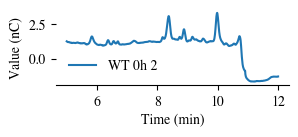

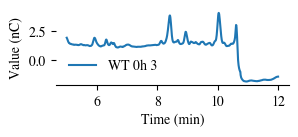

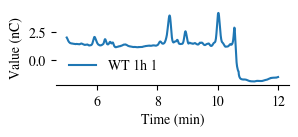

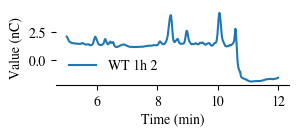

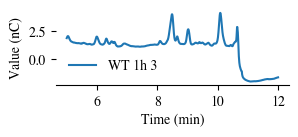

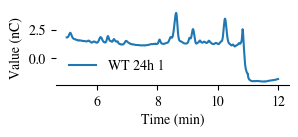

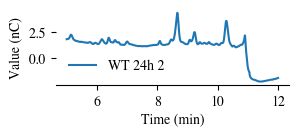

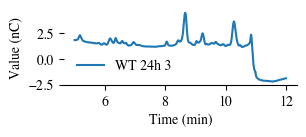

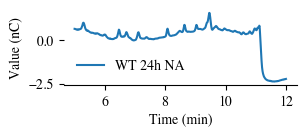

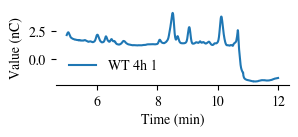

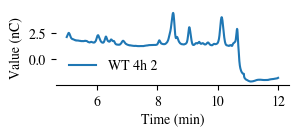

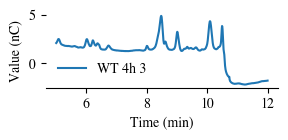

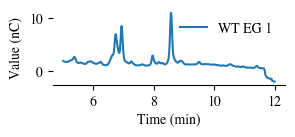

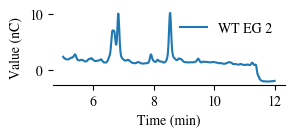

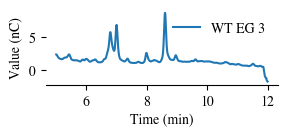

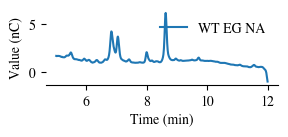

In [ ]:
for c in df:
    plot_ics_chrom(df, [c], figsize=(3,1), dpi=100, name_len=3)
#plt.close('all')


### Plots 3rd run

In [ ]:
path = '../03-Lab_work/Activity_assays/03-220526-Periplasm/Chrom/'

df_3 = get_run_df(path, skiprows=42, sort_cols=True, rezex=False, name_len=4, idx_inj=99).set_index('time')

In [ ]:
df_3

2C3_PI_1_24h  2C3_PI_1_EG  2C3_PI_2_24h  2C3_PI_2_EG  2C3_PI_NA_24h  \
time                                                                           
0.0000       -0.03955     -0.06780      -0.04370     -0.04795       -0.05410   
0.0083       -0.01875     -0.05400      -0.04605     -0.03245       -0.04035   
0.0167       -0.01045     -0.04970      -0.04035     -0.02835       -0.03390   
0.0250        0.00005     -0.04315      -0.03745     -0.01320       -0.02495   
0.0333        0.00515     -0.03760      -0.02795      0.01000       -0.03395   
...               ...          ...           ...          ...            ...   
25.9667      -0.03910     -0.88105      -0.09550     -0.73655       -0.28365   
25.9750      -0.03525     -0.87960      -0.09025     -0.73955       -0.28250   
25.9833      -0.03635     -0.87880      -0.08555     -0.73505       -0.28155   
25.9917      -0.03525     -0.87275      -0.07715     -0.73610       -0.28010   
26.0000      -0.03640     -0.86395      -0.07480     -0.73080       -0.28040   

         2C3_PI_NA_EG  2C3_PI_NS_24h  2C3_PI_NS_EG  4C1_PNI_1_24h  \
time                                                                
0.0000       -0.04795        0.01090      -0.01650       -0.05350   
0.0083       -0.03890       -0.04945      -0.07000       -0.04190   
0.0167       -0.03205       -0.03315      -0.05975       -0.02830   
0.0250       -0.03405       -0.02770      -0.04920       -0.01720   
0.0333       -0.01925       -0.01565      -0.04730       -0.01075   
...               ...            ...           ...            ...   
25.9667      -0.57535       -0.04010      -0.16465        0.08340   
25.9750      -0.57430       -0.03775      -0.16295        0.08590   
25.9833      -0.57495       -0.03530      -0.16400        0.08935   
25.9917      -0.56960       -0.01675      -0.15590        0.08670   
26.0000      -0.56985       -0.02120      -0.15355        0.08555   

         4C1_PNI_1_EG  ...  C-NE_24h_23_ED  C-NE_EG_36_ED  \
time                   ...                                  
0.0000       -0.06235  ...        -0.04855       -0.06545   
0.0083       -0.04425  ...        -0.04415       -0.05500   
0.0167       -0.04030  ...        -0.04265       -0.04765   
0.0250       -0.03440  ...        -0.03770       -0.03975   
0.0333       -0.03005  ...        -0.03210       -0.03590   
...               ...  ...             ...            ...   
25.9667      -0.49760  ...        -0.26255       -0.60500   
25.9750      -0.49685  ...        -0.26425       -0.60065   
25.9833      -0.49645  ...        -0.26530       -0.60115   
25.9917      -0.49505  ...        -0.25820       -0.60080   
26.0000      -0.48920  ...        -0.25800       -0.59445   

         Std_C1ox_0,00125_08  Std_C1ox_0,00125_40  Std_C1ox_0,0025_07  \
time                                                                    
0.0000              -0.03330              0.00080            -0.05200   
0.0083              -0.02290             -0.02715            -0.03305   
0.0167              -0.01780             -0.01890            -0.03450   
0.0250              -0.00830             -0.01510            -0.02575   
0.0333              -0.00235             -0.00560            -0.02605   
...                      ...                  ...                 ...   
25.9667             -0.15555              0.01570            -0.10520   
25.9750             -0.15635              0.01940            -0.09800   
25.9833             -0.15295              0.02470            -0.09835   
25.9917             -0.15095              0.01730            -0.09505   
26.0000             -0.14085              0.02060            -0.09455   

         Std_C1ox_0,0025_39  Std_C1ox_0,005_06  Std_C1ox_0,005_38  \
time                                                                
0.0000             -0.02635           -0.04215           -0.04490   
0.0083             -0.05835           -0.02960           -0.02605   
0.0167             -0.04720           -0.01675    

[Text(0, -20.0, ''),
 Text(0, 0.0, ''),
 Text(0, 20.0, ''),
 Text(0, 40.0, ''),
 Text(0, 60.0, ''),
 Text(0, 80.0, ''),
 Text(0, 100.0, ''),
 Text(0, 120.0, ''),
 Text(0, 140.0, '')]

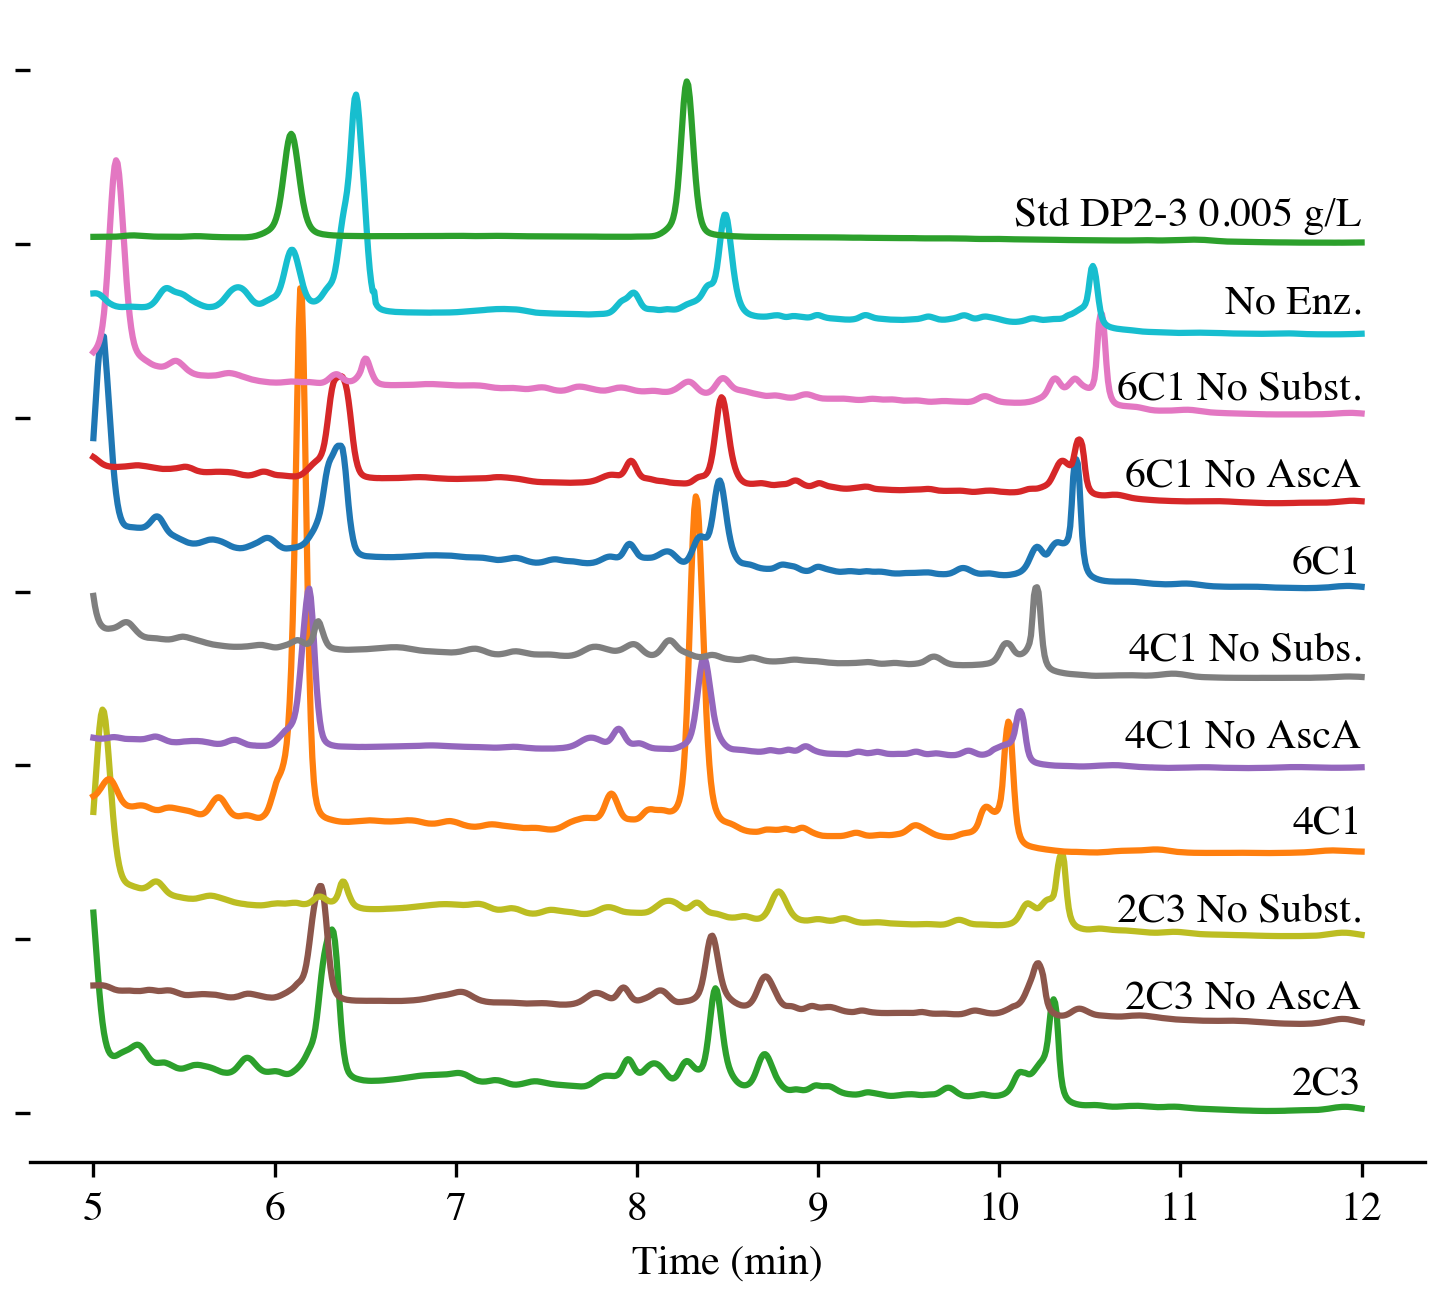

In [ ]:
nwlabs = ['2C3',
 '2C3 No AscA',
 '2C3 No Subst.',
 '4C1',
 '4C1 No AscA',
 '4C1 No Subs.',
 '6C1',
 '6C1 No AscA',
 '6C1 No Subst.',
 'No Enz.',
 'Std DP2-3 0.005 g/L']

cols = [c for c in df_3 if 'EG' in c and 'I_2' not in c] + ['Std_C1ox_0,005_06']
nwlabs = dict(zip(cols, nwlabs))
ax = plot_ics_chrom(df_3, cols, name_len=4, shifty=10, labshift=1, figsize=(6,5), nwlabs=nwlabs)
plt.ylabel('')
ax.set_yticklabels([])

### Plots 4th run

In [ ]:
path = '../03-Lab_work/Activity_assays/04-20220610-4_7/cellulose/raw/'


df_4 = get_run_df(path, skiprows=42, sort_cols=True, rezex=False, idx_inj=99).set_index('time')

In [ ]:
# df_4.columns.to_list()

In [ ]:
# [c for c in df_4 if '7' in c and 'pH6' in c]

In [ ]:
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]

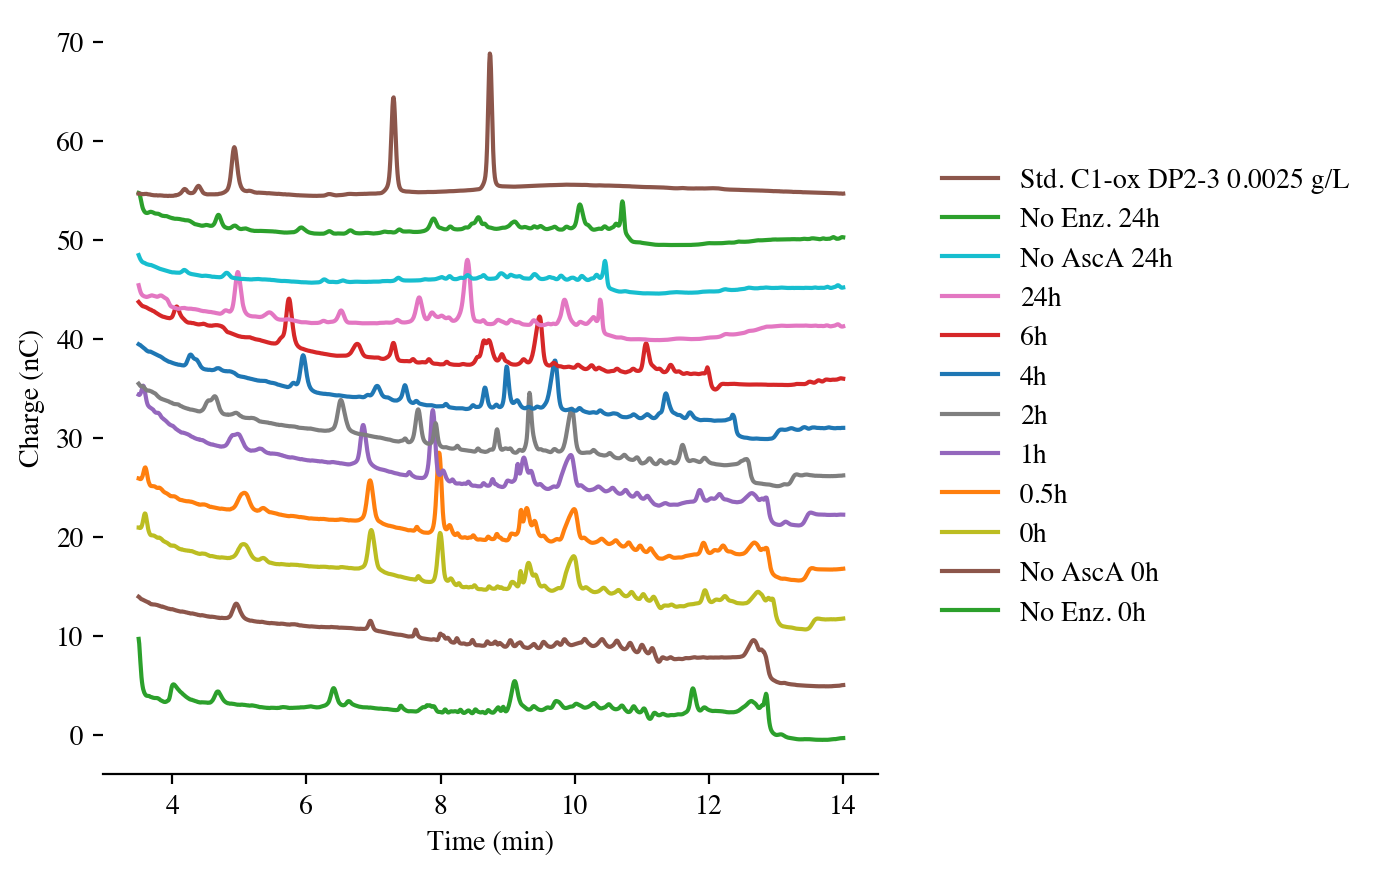

In [ ]:
cols = [ 

    'C-NE_00h-EGS_.txt',
    '7_00h-EGS_NA.txt',
    '7_00h-EGS_1.txt',
'7_00.5h-EGS_1.txt',
 '7_01h-EGS_1.txt',
 '7_02h-EGS_1.txt',
 '7_04h-EGS_1.txt',
 '7_06h-EGS_1.txt',
 '7_24h-EGS_1.txt',
        '7_24h-EGS_NA.txt',
    'C-NE_24h-EGS_.txt',
    'Std_C1ox-0.0025_2.txt',
]
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]
shifty=5
# colors = dict(zip(cols, sns.color_palette()[:len(cols)]))
# shiftx = dict(zip(cols, [-.06, 0.03, -0.18,0.01, 0.02, 0]))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3.5, x_max=14,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(5, 5), dpi=200,
#     color=colors
)

h, l = ax.get_legend_handles_labels()
legends = dict(zip(l, legs))

l = [legends[i] for i in l]
ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

shftx is dict, lims: 2.86, 13.7
sample: 7_24h-EGS-pH6_NA.txt  shiftx: 0.7
sample: 7_24h-EGS-pH6_1.txt  shiftx: 0.7
shftx is dict, lims: 2.86, 13.7
sample: 7_24h-EGS-pH6-Dil1-5_3.txt  shiftx: -0.14
sample: 7_24h-EGS-pH6-Std0.0025_1.txt  shiftx: -0.14
sample: 7_24h-EGS-pH6-Std0.005_2.txt  shiftx: -0.14
shftx is dict, lims: 2.86, 13.7
sample: Std_C1ox-0.00125_1.txt  shiftx: 0


Text(0.5, 0, 'Time (min)')

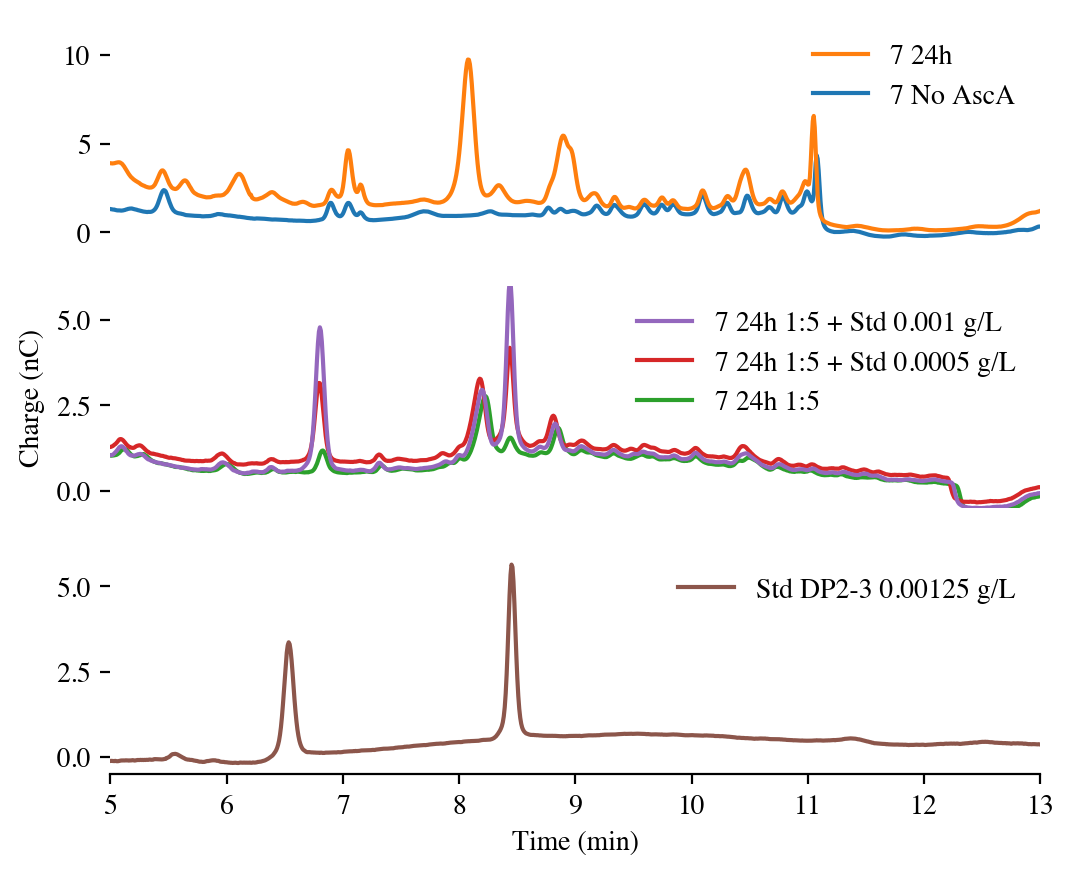

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

In [ ]:
legso = ['7 24h-EGS-pH6 NA.txt',
         '7 24h-EGS-pH6 1.txt',
         '7 24h-EGS-pH6-Dil1-5 3.txt',
         '7 24h-EGS-pH6-Std0.0025 1.txt',
         '7 24h-EGS-pH6-Std0.005 2.txt',
         'Std C1ox-0.00125 1.txt'
]
legsf = ['7 No AscA',
         '7 24h',
         '7 24h 1:5',
         '7 24h 1:5 + Std 0.0005 g/L',
         '7 24h 1:5 + Std 0.001 g/L',
         'Std DP2-3 0.00125 g/L'
]
legs = dict(zip(legso, legsf))

x_min=3
x_max=13
cols = [
#     'ne_24h-EGS_', 
    '7_24h-EGS-pH6_NA.txt',
         '7_24h-EGS-pH6_1.txt',
'7_24h-EGS-pH6-Dil1-5_3.txt',
 '7_24h-EGS-pH6-Std0.0025_1.txt',
 '7_24h-EGS-pH6-Std0.005_2.txt',
 'Std_C1ox-0.00125_1.txt',

#         'CelS2_24h-EGS_1.txt',
]

colors = dict(zip(cols, sns.color_palette()[:len(cols)]))

shiftsx = [
    0,
    -0.14,
    -0.14,
    -0.14,
    0.7,
    0.7,
#     0,
]
shiftsy = [
    15,
    9,
    9,
    9,
    0,
    0,
]

shiftsx = shiftsx[::-1]
shiftsy = shiftsy[::-1]

shiftx = dict(zip(cols, shiftsx))
shifty = 0 #dict(zip(cols, shiftsy))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,5), dpi=200, sharex=False)
# Make a plot
plot_ics_chrom(df_4, cols[:2], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax1)
plot_ics_chrom(df_4, cols[2:5], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax2)
plot_ics_chrom(df_4, cols[5:], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax3)

for ax in (ax1, ax2, ax3):
    ax.set_xlim(5, x_max)
    ax.set_ylim(-0.5, 6)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    l = [legs[i] for i in l]
    ax.legend(h[::-1], l[::-1],
#               bbox_to_anchor=[1.05, 0.5], 
              loc='upper right',
              frameon=False)
ax3.set_ylabel('')
ax1.set_ylabel('')
ax1.set_ylim(-0.5, 12)
# ax.set_yticklabels([])
# ax.set_yticks([])
sns.despine(fig=fig, left=True)
sns.despine(ax=ax1, bottom=True, left=True)
sns.despine(ax=ax2, bottom=True, left=True)
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xlabel('Time (min)')

In [ ]:
# [c for c in df_4 if 'td' in c]

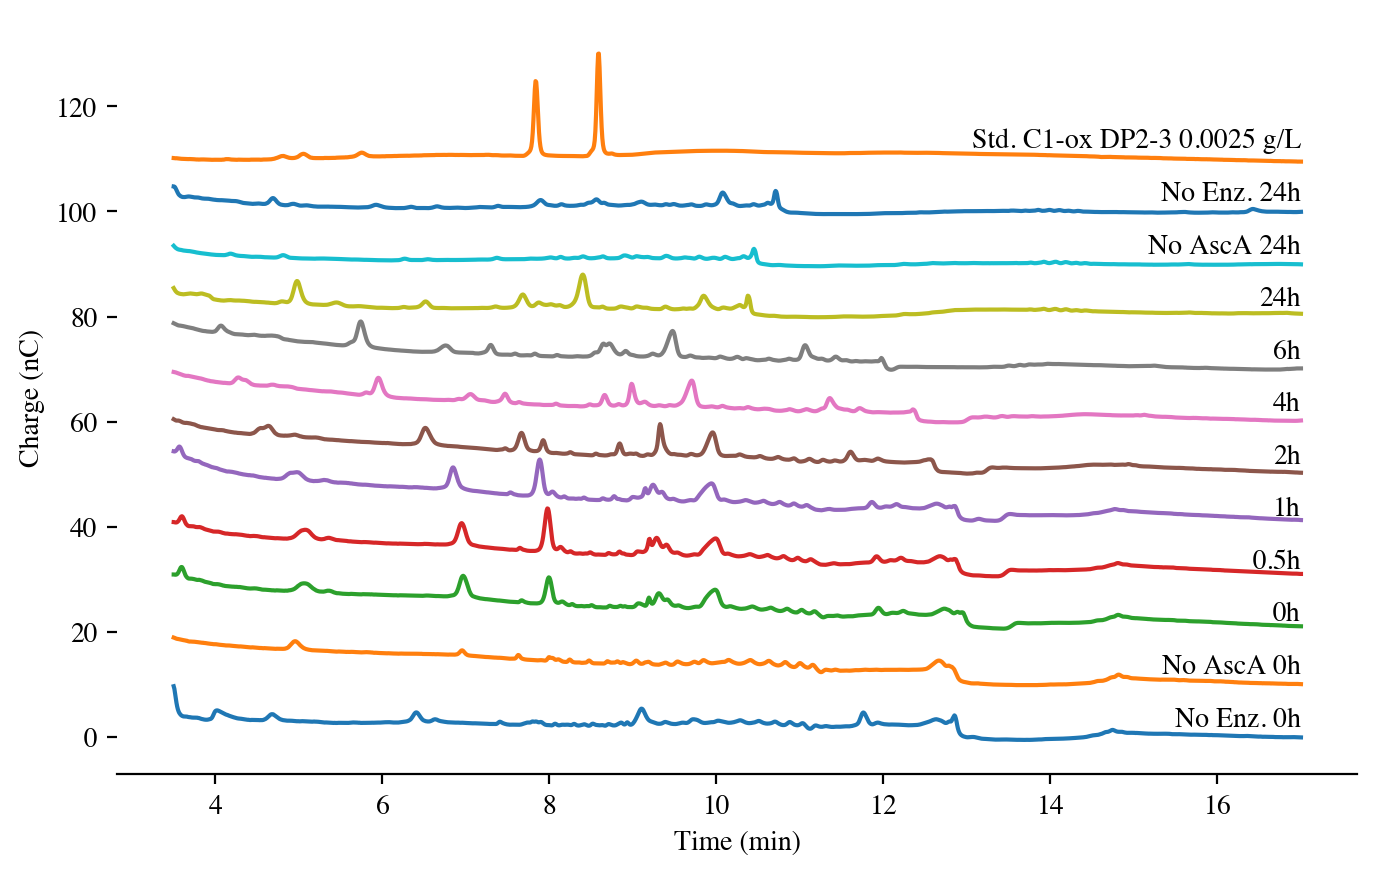

In [ ]:
cols = [ 
    'C-NE_00h-EGS_.txt',
    '7_00h-EGS_NA.txt',
    '7_00h-EGS_1.txt',
    '7_00.5h-EGS_1.txt',
    '7_01h-EGS_1.txt',
    '7_02h-EGS_1.txt',
    '7_04h-EGS_1.txt',
    '7_06h-EGS_1.txt',
    '7_24h-EGS_1.txt',
    '7_24h-EGS_NA.txt',
    'C-NE_24h-EGS_.txt',
    'Std_C1ox-0.0025_3.txt',
]
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=10
colors = dict(zip(cols, (sns.color_palette('tab10', len(cols)))))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3.5, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 5), dpi=200,
    color=colors, nwlabs=nwlabs, labshift=1
)

# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

#### Protein 4 vs CelS2

In [ ]:
# [c for c in df_4 if 'ox' in c]

Text(0.5, 0, '')

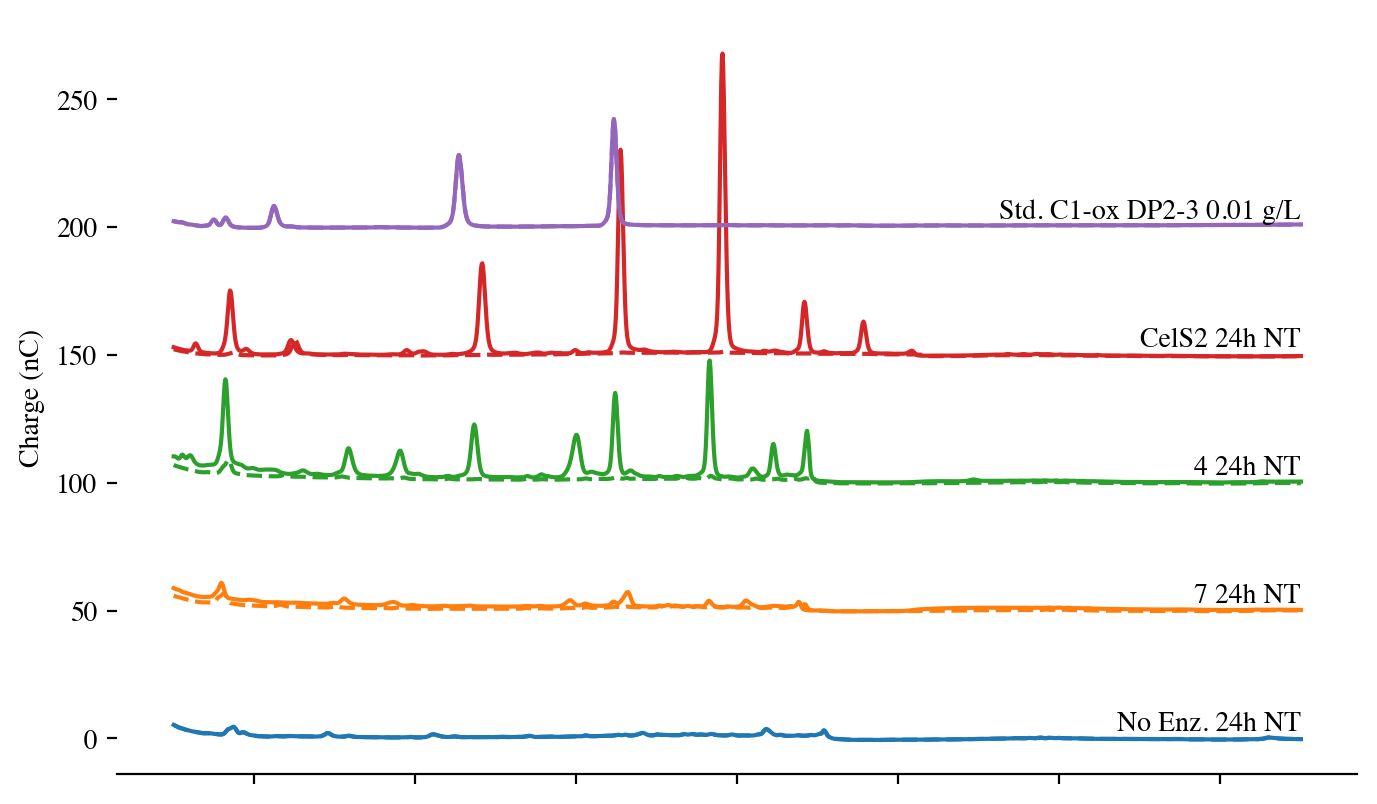

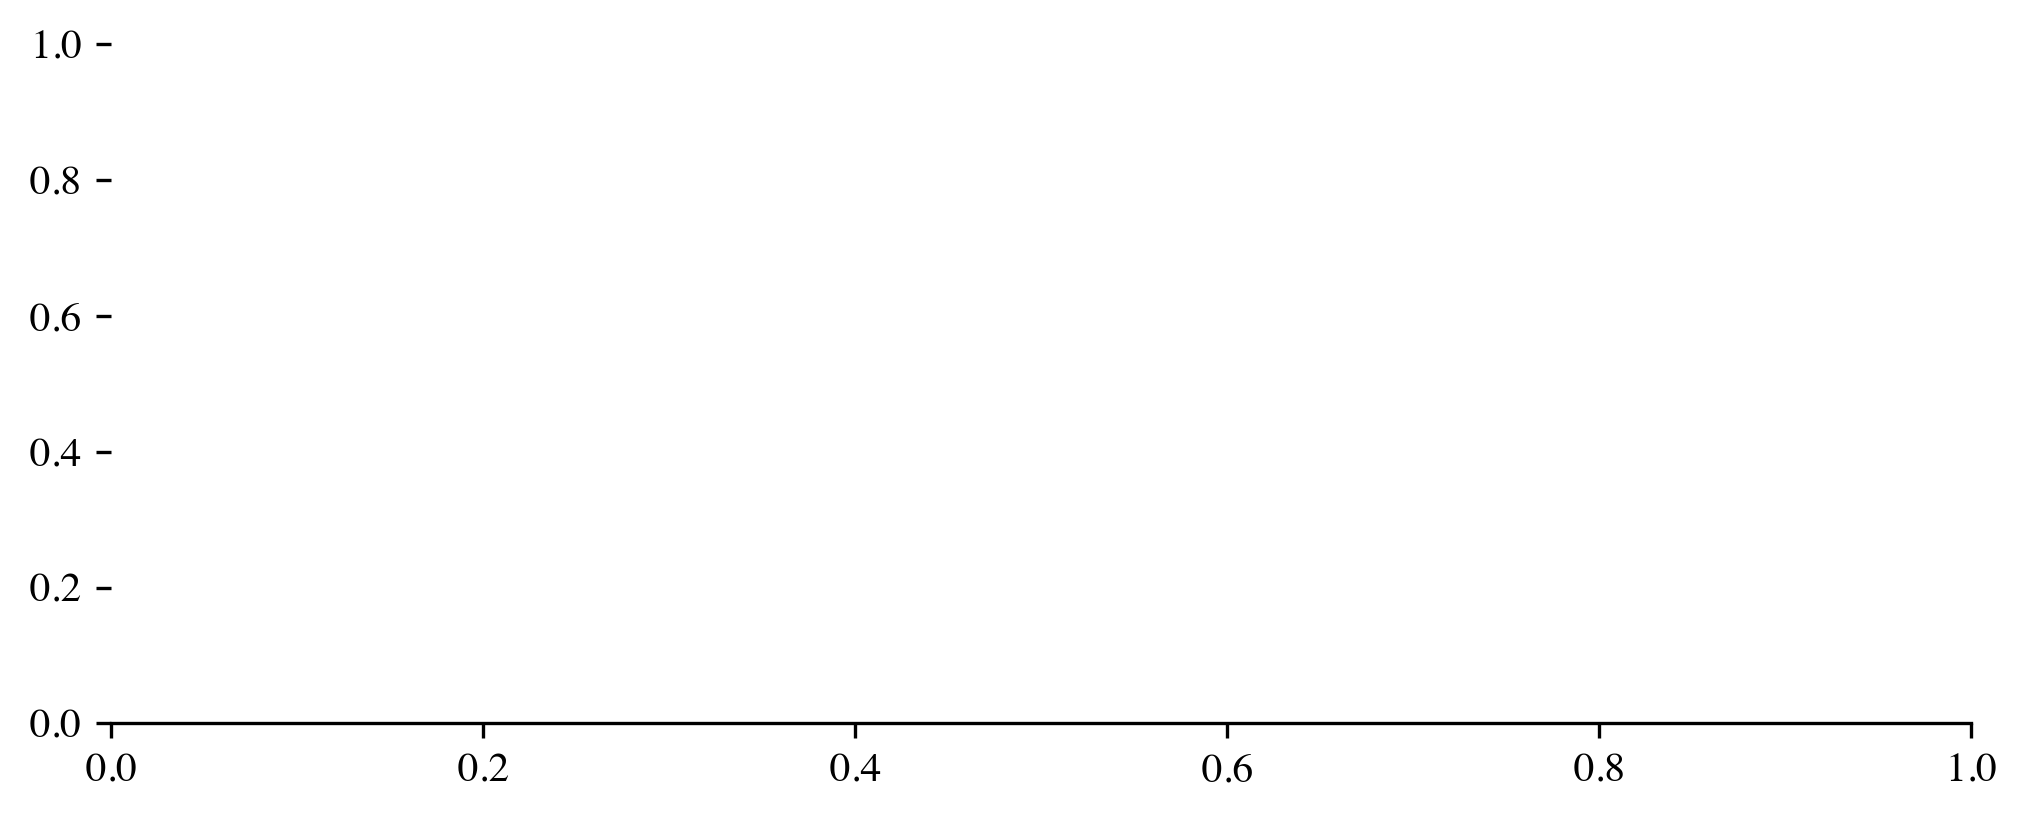

In [ ]:
cols_2 = [ 
    'C-NE_24h-NT_.txt',
#     '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
    '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
    '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
    'CelS2_24h-NT_NA.txt',
     'Std_C1ox-0.01_1.txt',

]
cols = [ 
    'C-NE_24h-NT_.txt',
    '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
#     '7_24h-NT_NA.txt',
    '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
    'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
     'Std_C1ox-0.01_1.txt',

]
legs = ['No Enz. 24h NT',
 '7 24h NT',
 '4 24h NT',
 'CelS2 24h NT',
 'Std. C1-ox DP2-3 0.01 g/L',
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=50
colors = dict(zip(cols, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols)]))
colors_2 = dict(zip(cols_2, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols_2)]))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 5), dpi=200,
    color=colors,
    nwlabs=nwlabs,
    labshift=1
)

ax = plot_ics_chrom(
    df_4, cols_2, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(6, 3), dpi=200,
    color=colors_2, style='--',
#     nwlabs=nwlabs,
    labshift=1, ax=ax, unlabel=True
)
# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xlabel('')

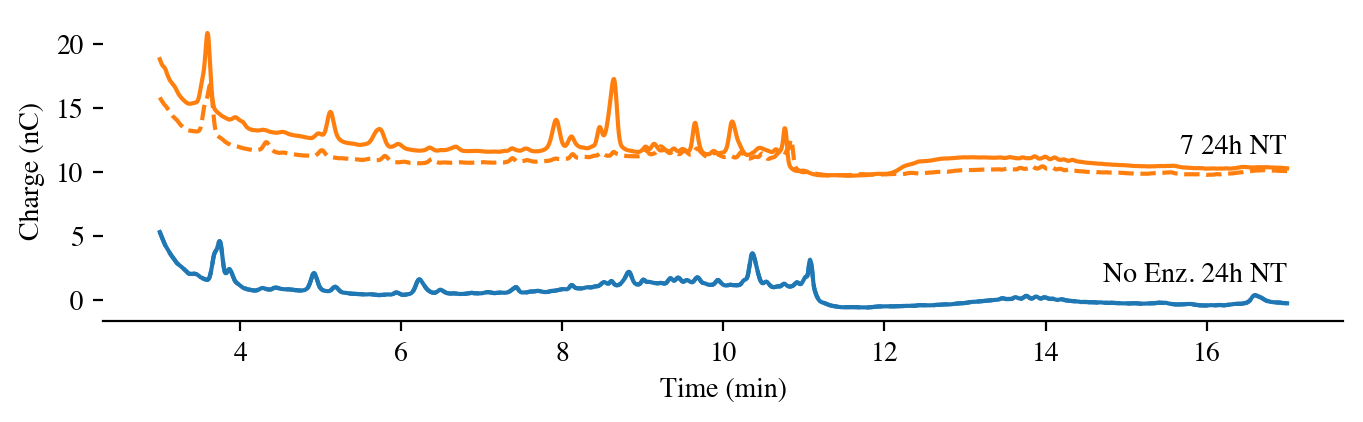

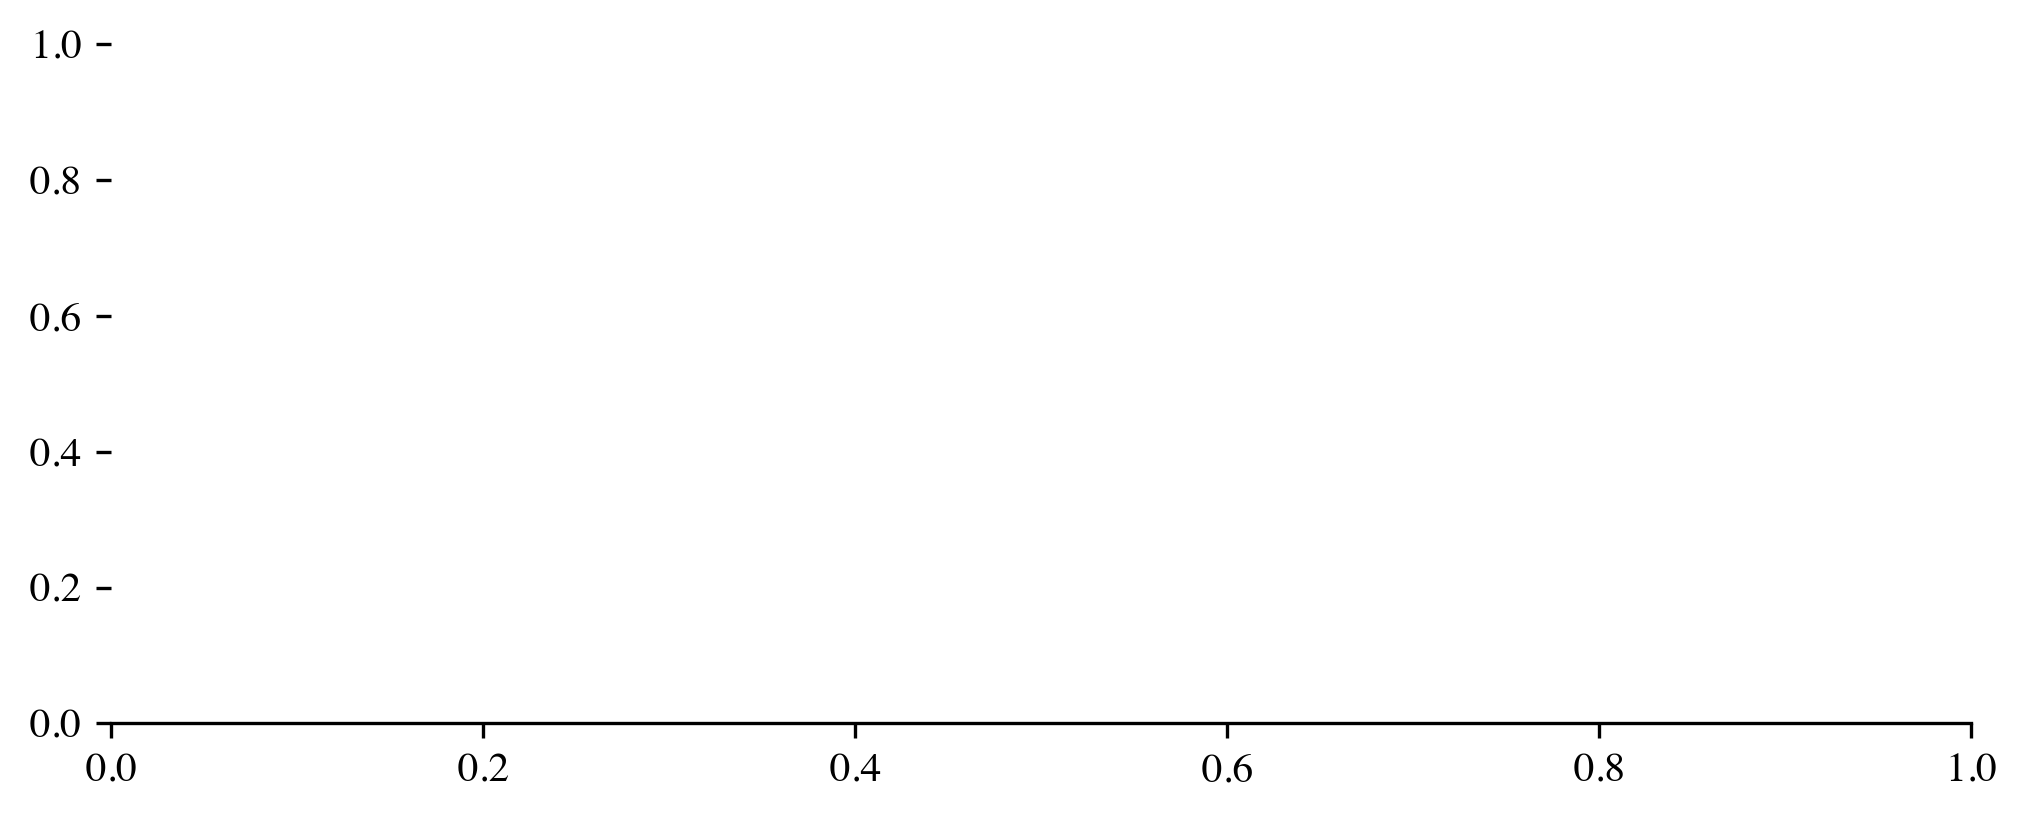

In [ ]:
cols_2 = [ 
    'C-NE_24h-NT_.txt',
#     '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
    '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
#      'Std_C1ox-0.00125_1.txt',

]
cols = [ 
    'C-NE_24h-NT_.txt',
    '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
#     '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
#      'Std_C1ox-0.00125_1.txt',

]
legs = [
    'No Enz. 24h NT',
 '7 24h NT',
#  '4 24h NT',
#  'CelS2 24h NT',
#  'Std. C1-ox DP2-3 0.00125 g/L',
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=10
colors = dict(zip(cols, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols)]))
colors_2 = dict(zip(cols_2, sns.color_palette()[:len(cols_2)]))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 2), dpi=200,
    color=colors,
    nwlabs=nwlabs,
    labshift=1
)

ax = plot_ics_chrom(
    df_4, cols_2, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(6, 3), dpi=200,
    color=colors_2, style='--',
#     nwlabs=nwlabs,
    labshift=1, ax=ax, unlabel=True
)
# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

### Plots 5th run

In [ ]:
path = '../03-Lab_work/Activity_assays/05-20220613-WT_4a_7/raw/'


In [ ]:
df_5 = get_run_df(path, skiprows=42, sort_cols=True, rezex=False, idx_inj=-1).set_index('time')

In [ ]:
df_5.columns.to_list()

['4a_24h-EGS_1',
 '4a_24h-EGS_2',
 '4a_24h-EGS_na',
 '7_24h-EGS_1',
 '7_24h-EGS_2',
 '7_24h-EGS_na',
 'Std_C1ox-0.00125_13.txt',
 'Std_C1ox-0.00125_14.txt',
 'Std_C1ox-0.00125_15.txt',
 'Std_C1ox-0.0025_12.txt',
 'Std_C1ox-0.005_11.txt',
 'ne_24h-EGS_',
 'wt_24h-EGS_1',
 'wt_24h-EGS_2',
 'wt_24h-EGS_na']

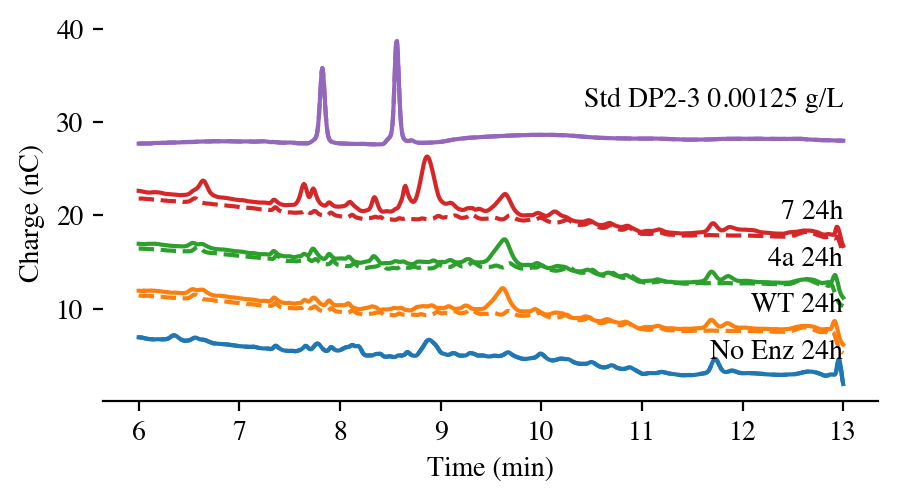

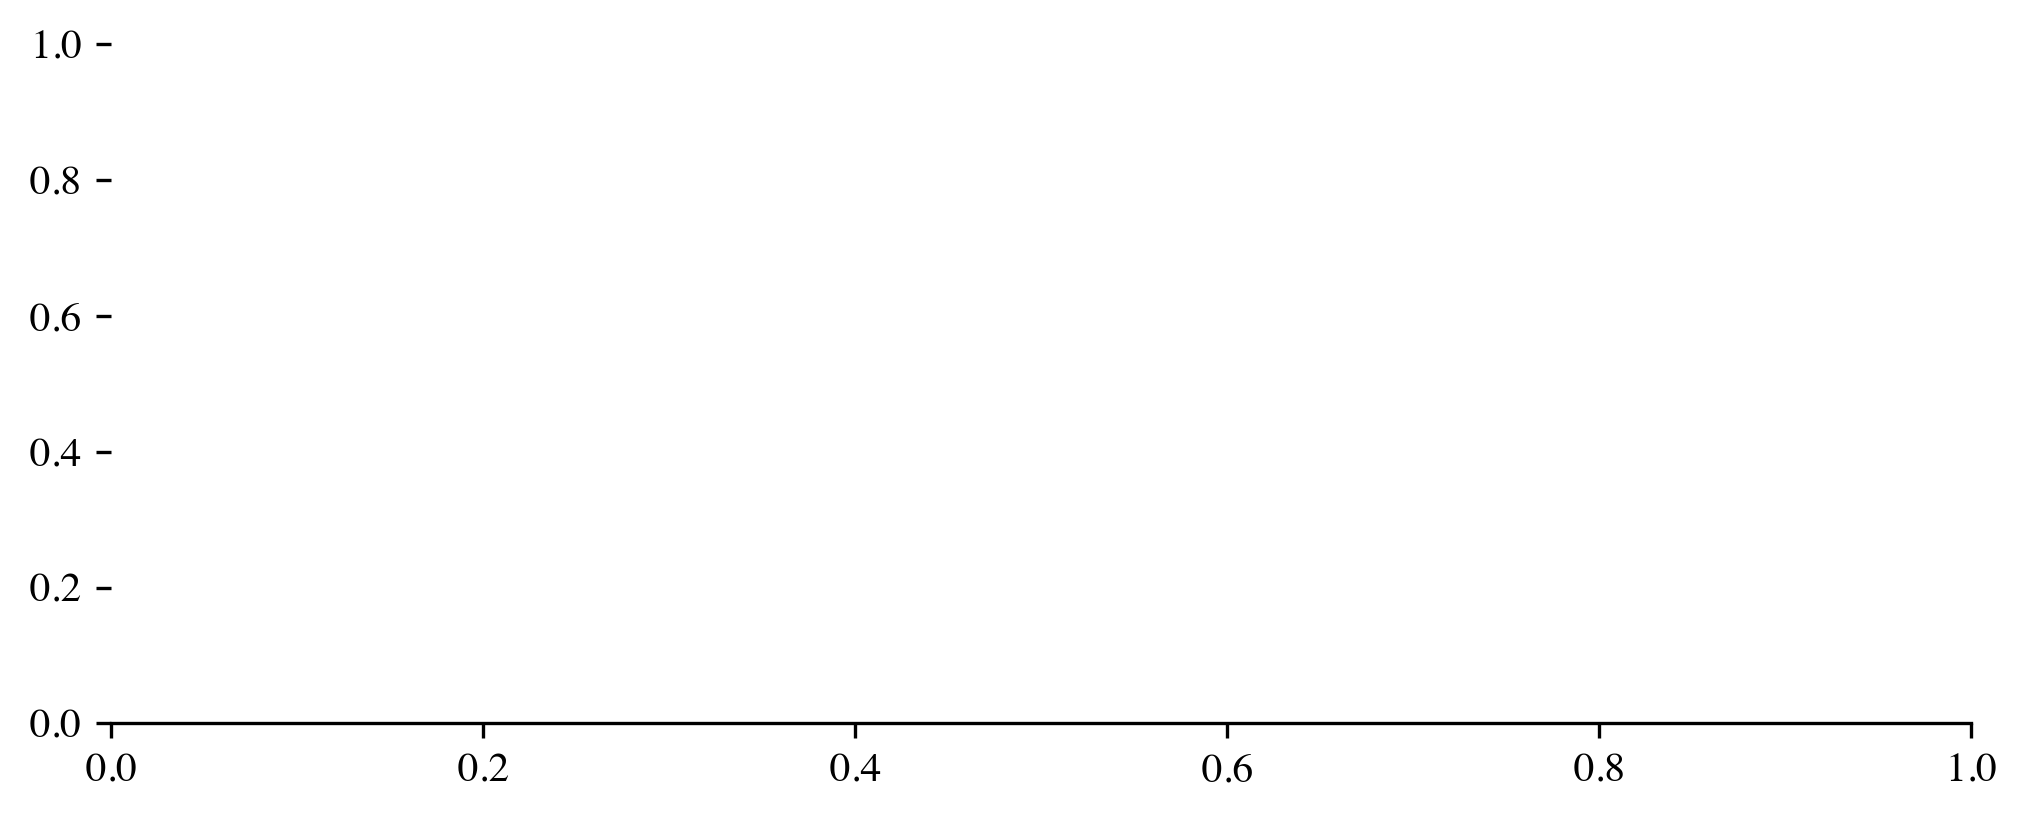

In [ ]:
legsf = ['No Enz 24h',
 'WT 24h',
 '4a 24h',
 '7 24h',
 'Std DP2-3 0.00125 g/L']

shiftys = [
    0,
    5,
    10,
    15,
    27
]

# cols = [c for c in df if '0,01_x' in c]+[c for c in df if 'EG_1' in c]
cols = [
#  'Std_C1ox-0.00125_13.txt',
#  'Std_C1ox-0.00125_14.txt',
#      'Std_C1ox-0.00125_2.txt',
 'ne_24h-EGS_',
#  'wt_24h-EGS_1',
 'wt_24h-EGS_2',
#  'wt_24h-EGS_na',
#     '4a_24h-EGS_1',
 '4a_24h-EGS_2',
#  '4a_24h-EGS_na',
#  '7_24h-EGS_1',
 '7_24h-EGS_2',
#  '7_24h-EGS_na',
#  'Std_C1ox-0.005_11.txt',
#  'Std_C1ox-0.0025_12.txt',
#  'Std_C1ox-0.00125_13.txt',
 'Std_C1ox-0.00125_15.txt',
]
nwlabs = dict(zip(cols, legsf))
colors = dict(zip(cols, sns.color_palette()[:len(cols)]))
# shiftx = dict(zip(cols, [-.06, 0.03, -0.18,0.01, 0.02, 0]))
shifty = dict(zip(cols, shiftys))

# Make a plot
ax = plot_ics_chrom(
    df_5, cols, 
    log_y=False, 
    x_min=6, x_max=13,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(5, 2.5), dpi=200,
    color=colors, nwlabs=nwlabs, labshift=4
)

# plt.title('Insoluble fraction')

cols_2 = [
#  'Std_C1ox-0.00125_13.txt',
#  'Std_C1ox-0.00125_14.txt',
#      'Std_C1ox-0.00125_2.txt',

 'ne_24h-EGS_',
#  'wt_24h-EGS_1',
#  'wt_24h-EGS_2',
 'wt_24h-EGS_na',
#     '4a_24h-EGS_1',
#  '4a_24h-EGS_2',
 '4a_24h-EGS_na',
#  '7_24h-EGS_1',
#  '7_24h-EGS_2',
 '7_24h-EGS_na',
 'Std_C1ox-0.00125_15.txt',
]


colors = dict(zip(cols_2, sns.color_palette('tab10')[:len(cols_2)]))
# shiftx = dict(zip(cols_2, [-.06, 0.03, -.23,-0.24,-0.14]))
shifty = dict(zip(cols_2, shiftys))
plot_ics_chrom(
    df_5, cols_2, 
    log_y=False, 
    x_min=6, x_max=13,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(5, 3.5), dpi=100,
    ax=ax, style='--', color=colors, unlabel=True
);
# ax.set_xlim(6, 10)
# h, l = ax.get_legend_handles_labels()

# l = [legs[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

## Rezex

In [ ]:
path_rz = '../03-Lab_work/Activity_assays/04-20220610-4_7/chitin/raw/'
path_rz = '../03-Lab_work/Activity_assays/04-20220610-4_7/chitin/raw/'

In [ ]:
df_rz = get_run_df(path_rz, skiprows=42, sort_cols=True, rezex=True)

In [ ]:
df_rz = df_rz.set_index('time')

In [ ]:
df_rz

4_00.5h-ChiBS_1  4_00.5h-ChiBS_2  4_00.5h-ChiBS_3  4_00h-ChiBS_1  \
time                                                                       
0.0000        -0.053158        -0.013200        -0.020542      -0.051451   
0.0017        -0.095302        -0.047054        -0.053504      -0.070525   
0.0033        -0.034402        -0.036423        -0.020797      -0.062849   
0.0050        -0.047055        -0.034664        -0.002124      -0.055716   
0.0067        -0.044345        -0.016598        -0.033700      -0.046779   
...                 ...              ...              ...            ...   
5.9933         0.043151         0.052005         0.003935       0.058884   
5.9950         0.016822         0.061936         0.050385       0.045013   
5.9967         0.078526         0.066574         0.005963       0.095110   
5.9983         0.045884         0.021582         0.053757       0.106010   
6.0000         0.049270         0.010004         0.000646       0.075879   

        4_00h-ChiBS_2  4_00h-ChiBS_3  4_00h-ChiBS_NA  4_01h-ChiBS_1  \
time                                                                  
0.0000      -0.048819      -0.042612       -0.029342       0.004005   
0.0017      -0.074292      -0.079619       -0.065539      -0.039420   
0.0033      -0.064553      -0.064705       -0.048639      -0.022337   
0.0050      -0.056458      -0.045993       -0.081228      -0.035164   
0.0067      -0.071770      -0.075393       -0.029731      -0.040836   
...               ...            ...             ...            ...   
5.9933       0.017441      -0.042687       -0.038897       0.115375   
5.9950      -0.029569      -0.072773       -0.041119       0.139155   
5.9967       0.017756      -0.094178       -0.007866       0.093682   
5.9983       0.016255      -0.074279       -0.007295       0.130228   
6.0000       0.001789      -0.048504       -0.036225       0.070535   

        4_01h-ChiBS_2  4_01h-ChiBS_3  ...  Sc10D_24h-ChiBI_3  \
time                                  ...                      
0.0000      -0.065564      -0.045387  ...          -0.082952   
0.0017      -0.041741      -0.022089  ...          -0.061136   
0.0033      -0.103244       0.006707  ...          -0.052966   
0.0050      -0.098460      -0.015680  ...          -0.073187   
0.0067      -0.056026      -0.102746  ...          -0.056612   
...               ...            ...  ...                ...   
5.9933      -0.075056       0.074991  ...           0.130731   
5.9950      -0.013278       0.061540  ...           0.115391   
5.9967      -0.018169       0.077888  ...           0.110408   
5.9983      -0.051307       0.098802  ...           0.099561   
6.0000      -0.011638       0.066452  ...           0.132611   

        Sc10D_24h-ChiBI_NA  Sc10D_24h-ChiBS_1  Sc10D_24h-ChiBS_2  \
time                                                               
0.0000            0.003051          -0.002414          -0.039444   
0.0017           -0.039312          -0.004287          -0.083989   
0.0033           -0.025516          -0.027590          -0.070500   
0.0050           -0.008335          -0.011435          -0.073952   
0.0067           -0.020533           0.002968          -0.120805   
...                    ...                ...                ...   
5.9933           -0.055306           0.561160           0.432192   
5.9950           -0.080874           0.598051           0.452722   
5.9967           -0.142318           0.539157           0.498514   
5.9983           -0.083185           0.561631           0.457837   
6.0000           -0.080038           0.563401           0.475350   

        Sc10D_24h-ChiBS_3  Sc10D_24h-ChiBS_NA  Sc10D_24h-NT_1  Sc10D_24h-NT_2  \
time                                                                            
0.0000          -0.112916           -0.115470        0.035134       -0.150372   
0.0017          -0.098561           -0.107046        0.036839       -0.193876   
0.0033          -0.089592           -0.157580        

In [ ]:
[c for c in df_rz if 'ox' in c and '' in c]

['A2ox_100µM_1',
 'A2ox_100µM_2',
 'A2ox_100µM_3',
 'A2ox_10µM_1',
 'A2ox_10µM_2',
 'A2ox_10µM_3',
 'A2ox_200µM_1',
 'A2ox_200µM_2',
 'A2ox_200µM_3',
 'A2ox_25µM_1',
 'A2ox_25µM_2',
 'A2ox_25µM_3',
 'A2ox_400µM_1',
 'A2ox_400µM_2',
 'A2ox_400µM_3',
 'A2ox_50µM_1',
 'A2ox_50µM_2',
 'A2ox_50µM_3',
 'A2ox_800µM_1',
 'A2ox_800µM_2',
 'A2ox_800µM_3']

In [ ]:
cols = [
#     u'Std_A2ox-800µM_10',
#      'Std_A2ox-50µM_06',
    'A2ox_100µM_1',
#     'Std_A2ox-10µM_04',
 'C-NE_24h-NT_',
    '4_24h-NT_1',
#  '4_24h-NT_2',
#  '4_24h-NT_3',
#  '4_24h-NT_NA',
 '7_24h-NT_1',
#  '7_24h-NT_2',
#  '7_24h-NT_3',
#  '7_24h-NT_NA',
 'Sc10D_24h-NT_1',
#  'Sc10D_24h-NT_2',
#  'Sc10D_24h-NT_3',
#  'Sc10D_24h-NT_NA',
]

In [ ]:
cols = [c for c in df_rz if 'Sc10D_24h' in c and 'ChiB' in c]
cols += ['A2ox_100µM_1']

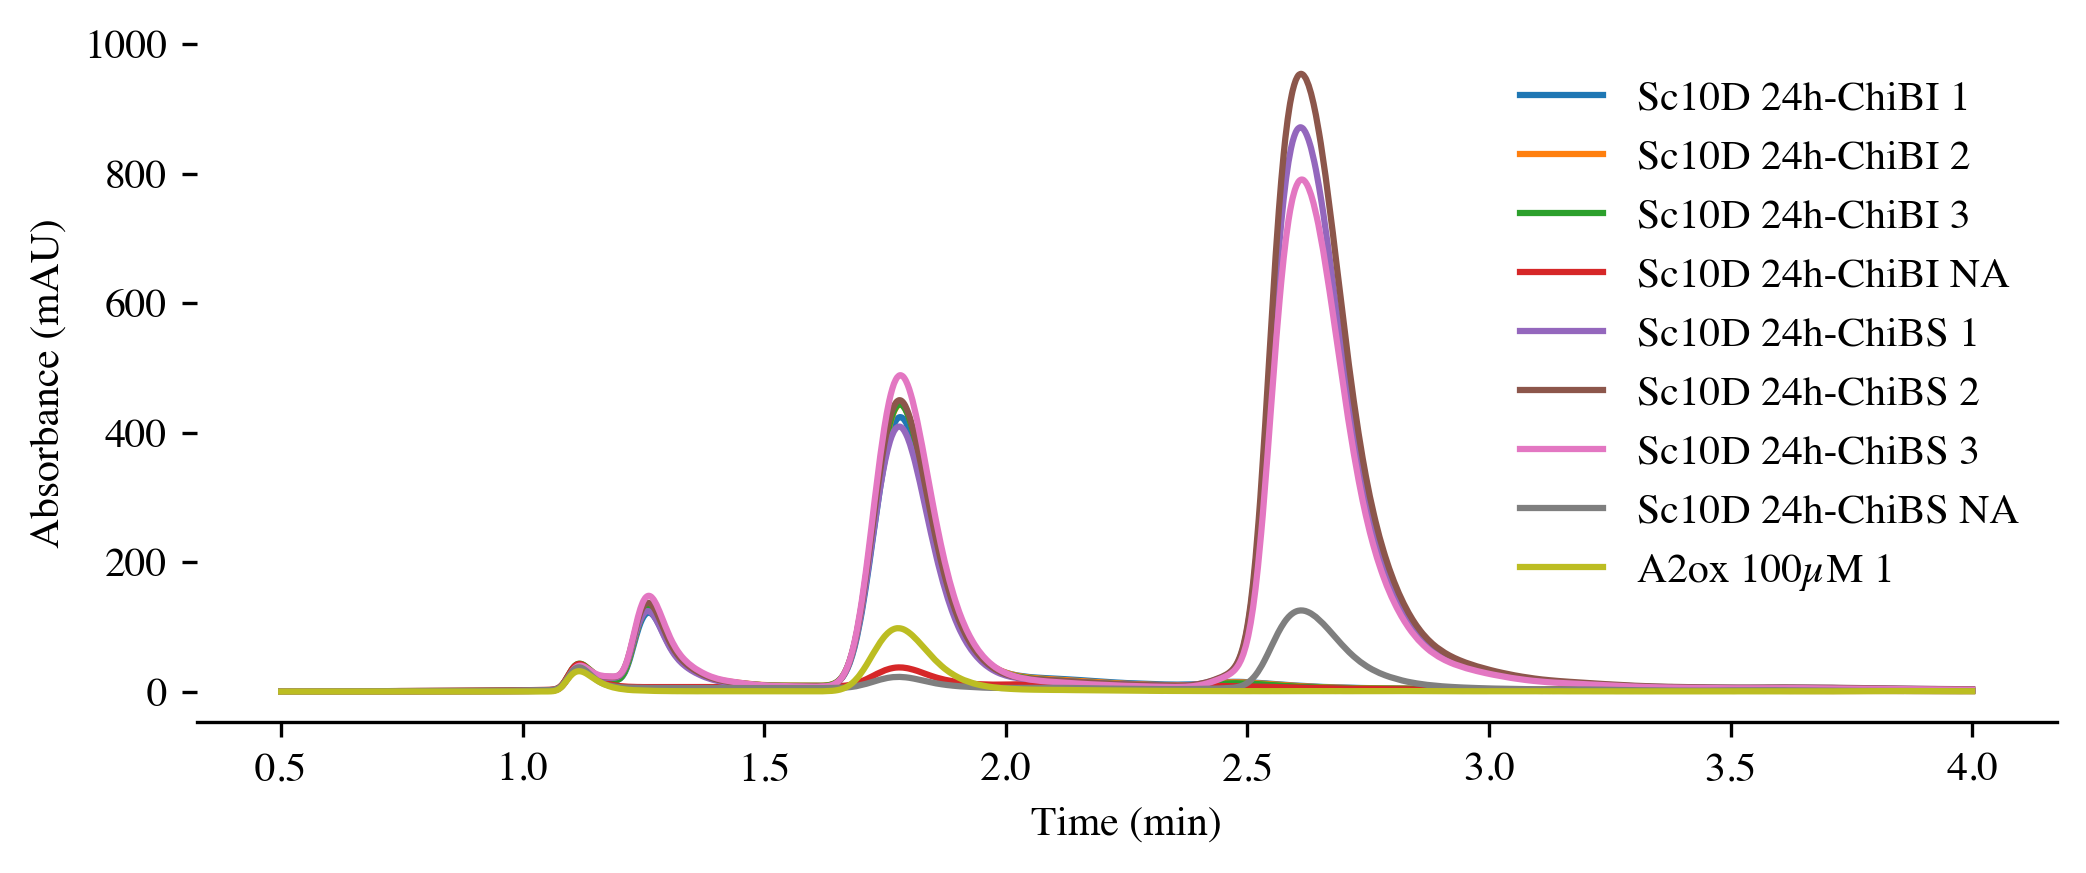

In [ ]:
ax = plot_ics_chrom(df_rz, cols, x_min=0.5, x_max=4, y_min=None, y_max=None, ax=None, 
                    log_y=False,
#                     shifty=150, shiftx=0,
                    name_len=3,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False)

In [ ]:
df_rz.columns.to_list()

['4_00.5h-ChiBS_1',
 '4_00.5h-ChiBS_2',
 '4_00.5h-ChiBS_3',
 '4_00h-ChiBS_1',
 '4_00h-ChiBS_2',
 '4_00h-ChiBS_3',
 '4_00h-ChiBS_NA',
 '4_01h-ChiBS_1',
 '4_01h-ChiBS_2',
 '4_01h-ChiBS_3',
 '4_02h-ChiBS_1',
 '4_02h-ChiBS_2',
 '4_02h-ChiBS_3',
 '4_04h-ChiBS_1',
 '4_04h-ChiBS_2',
 '4_04h-ChiBS_3',
 '4_06h-ChiBS_1',
 '4_06h-ChiBS_2',
 '4_06h-ChiBS_3',
 '4_24h-ChiBI_1',
 '4_24h-ChiBI_2',
 '4_24h-ChiBI_3',
 '4_24h-ChiBI_NA',
 '4_24h-ChiBS_1',
 '4_24h-ChiBS_2',
 '4_24h-ChiBS_3',
 '4_24h-ChiBS_NA',
 '4_24h-NT_1',
 '4_24h-NT_2',
 '4_24h-NT_3',
 '4_24h-NT_NA',
 '7_00.5h-ChiBS_1',
 '7_00.5h-ChiBS_2',
 '7_00.5h-ChiBS_3',
 '7_00h-ChiBS_1',
 '7_00h-ChiBS_2',
 '7_00h-ChiBS_3',
 '7_00h-ChiBS_NA',
 '7_01h-ChiBS_1',
 '7_01h-ChiBS_2',
 '7_01h-ChiBS_3',
 '7_02h-ChiBS_1',
 '7_02h-ChiBS_2',
 '7_02h-ChiBS_3',
 '7_04h-ChiBS_1',
 '7_04h-ChiBS_2',
 '7_04h-ChiBS_3',
 '7_06h-ChiBS_1',
 '7_06h-ChiBS_2',
 '7_06h-ChiBS_3',
 '7_24h-ChiBI_1',
 '7_24h-ChiBI_2',
 '7_24h-ChiBI_3',
 '7_24h-ChiBI_NA',
 '7_24h-ChiBS_1',
 '7_

In [ ]:
[c for c in df_rz if '24h-ChiBS_1' in c] + ['A2ox_100µM_1']

['4_24h-ChiBS_1', '7_24h-ChiBS_1', 'Sc10D_24h-ChiBS_1', 'A2ox_100µM_1']

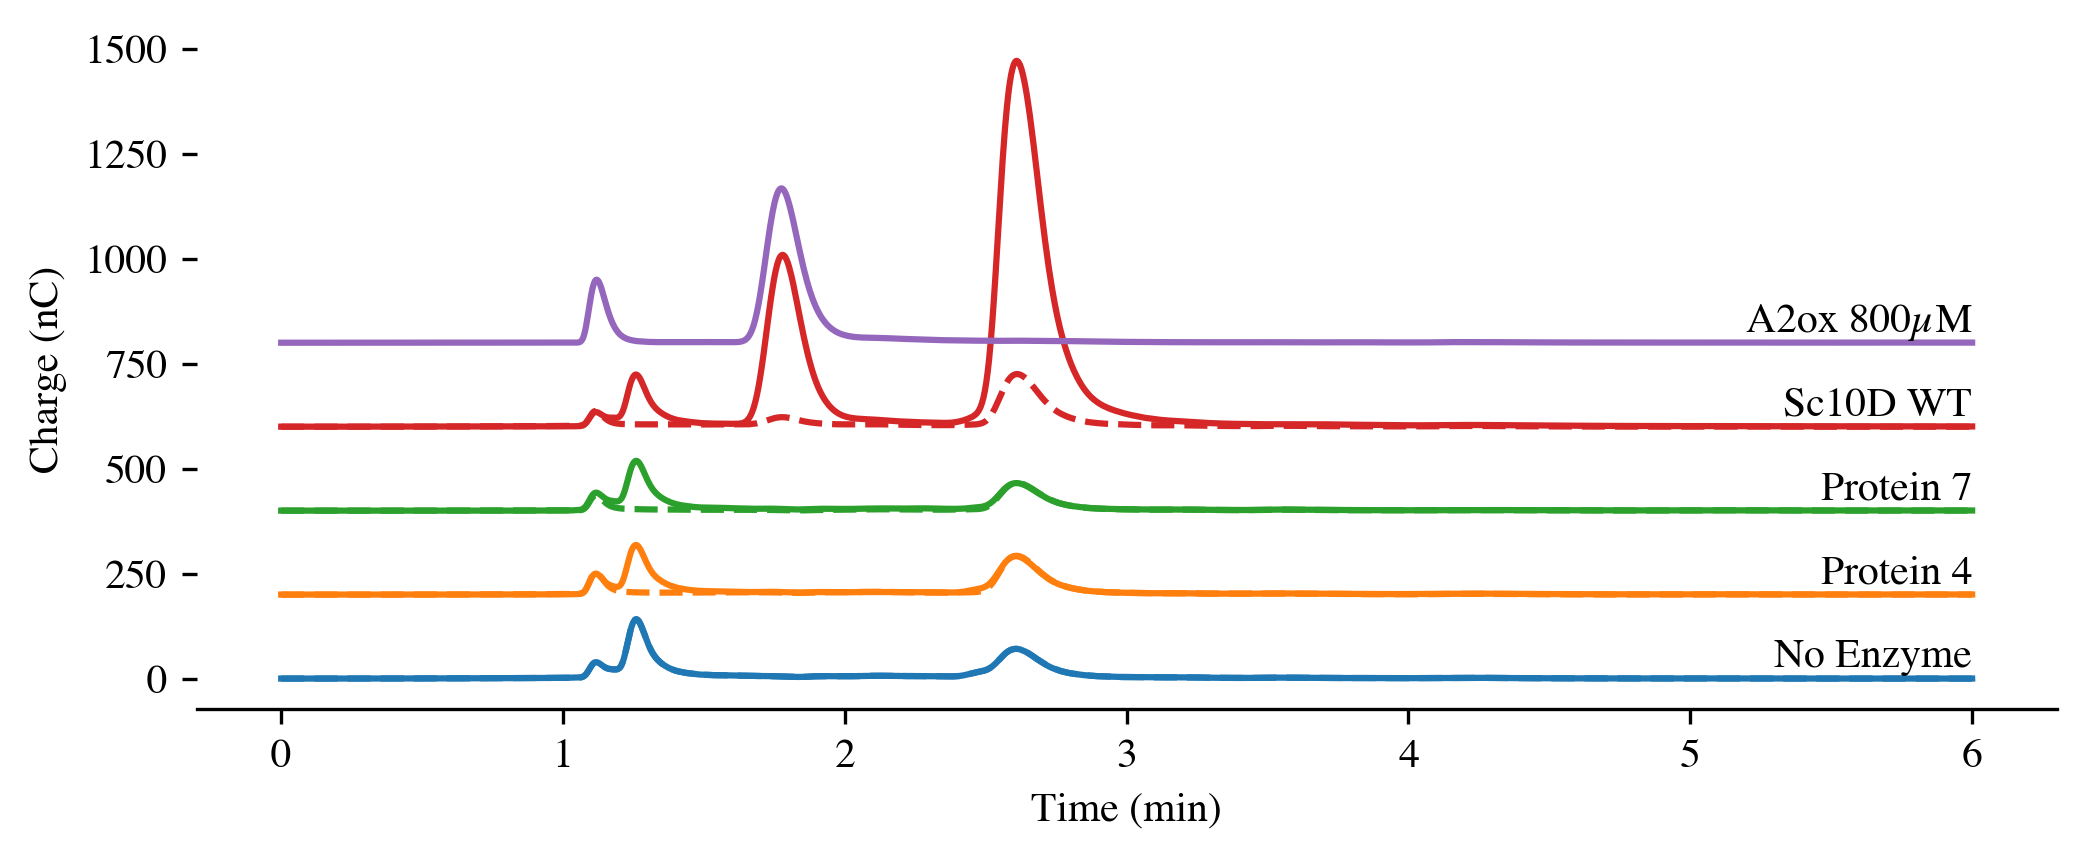

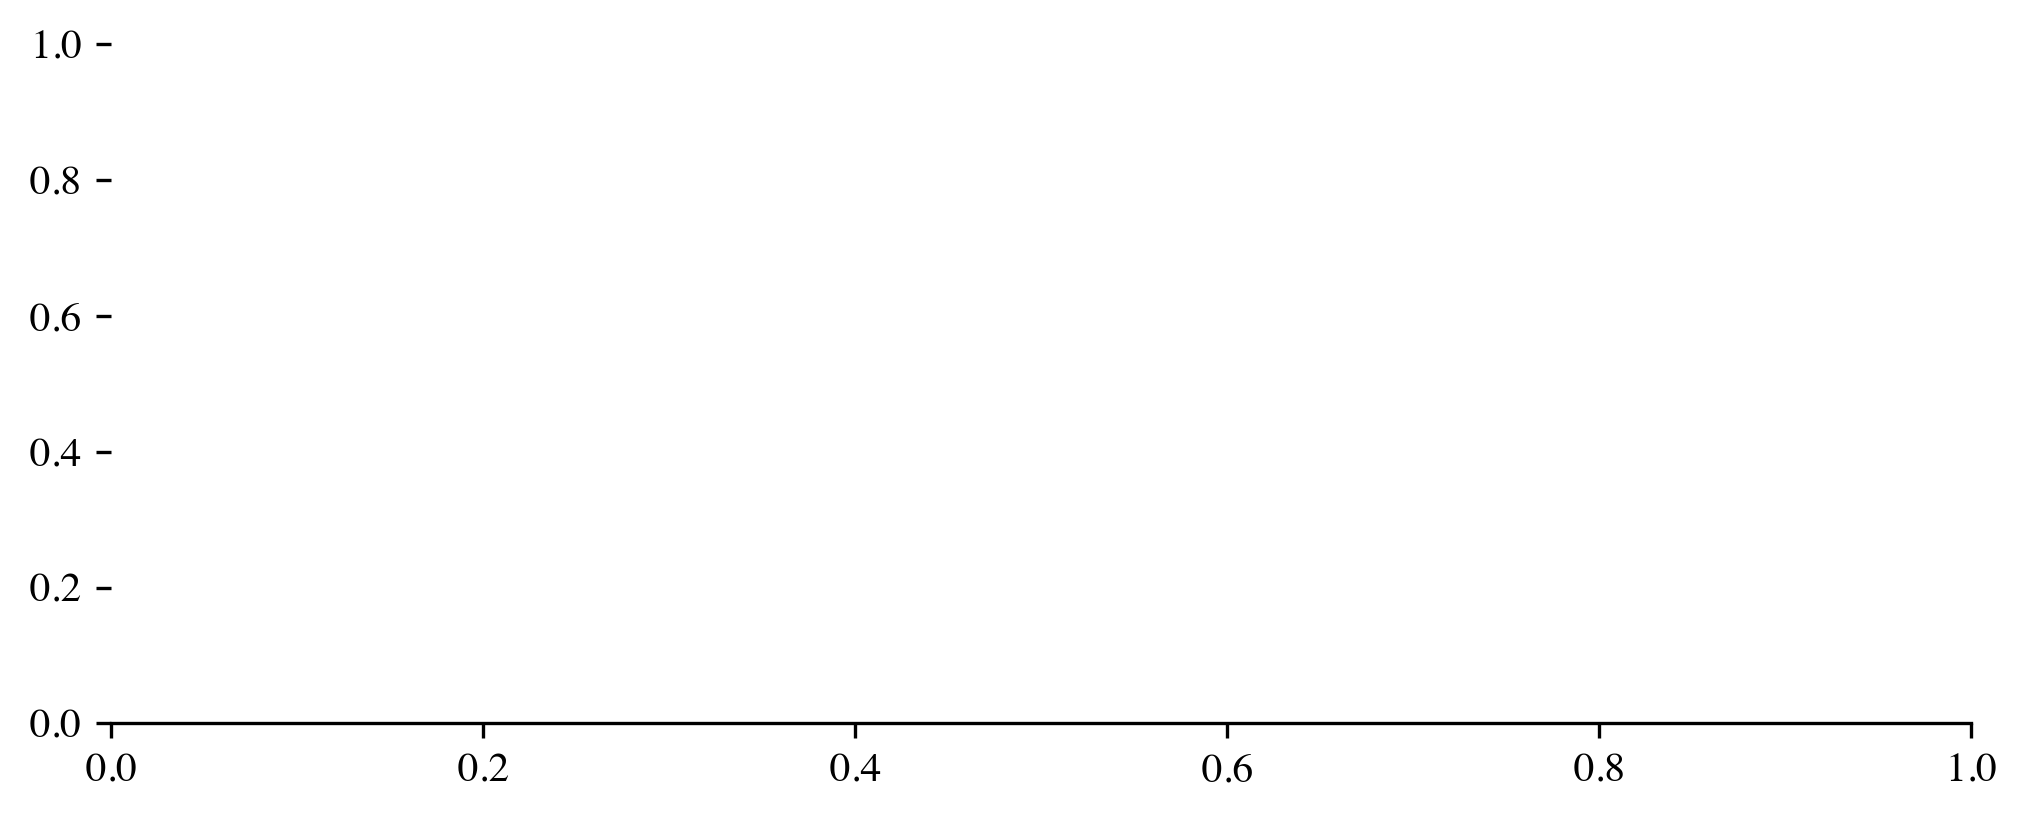

In [ ]:
cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_1' in c] + [ 'A2ox_800µM_1']
nwlabs = ['No Enzyme', 'Protein 4', 'Protein 7', 'Sc10D WT', 'A2ox 800µM']
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=200, shiftx=0, name_len=2,
                    figsize=(8,3), dpi=300, nwlabs=dict(zip(cols,nwlabs)),
                    ylabel='Absorbance (mAU)',color = colors,
                    no_negatives=False)

cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_NA' in c] #+ [ 'A2ox_100µM_1']

colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, 
                    ax=ax, style='--',
                    log_y=False, shifty=200, shiftx=0, name_len=2,
#                     figsize=(8,3), dpi=300,
                    unlabel=True,
#                     ylabel='Absorbance (mAU)',
                    color = colors,
                    no_negatives=False)

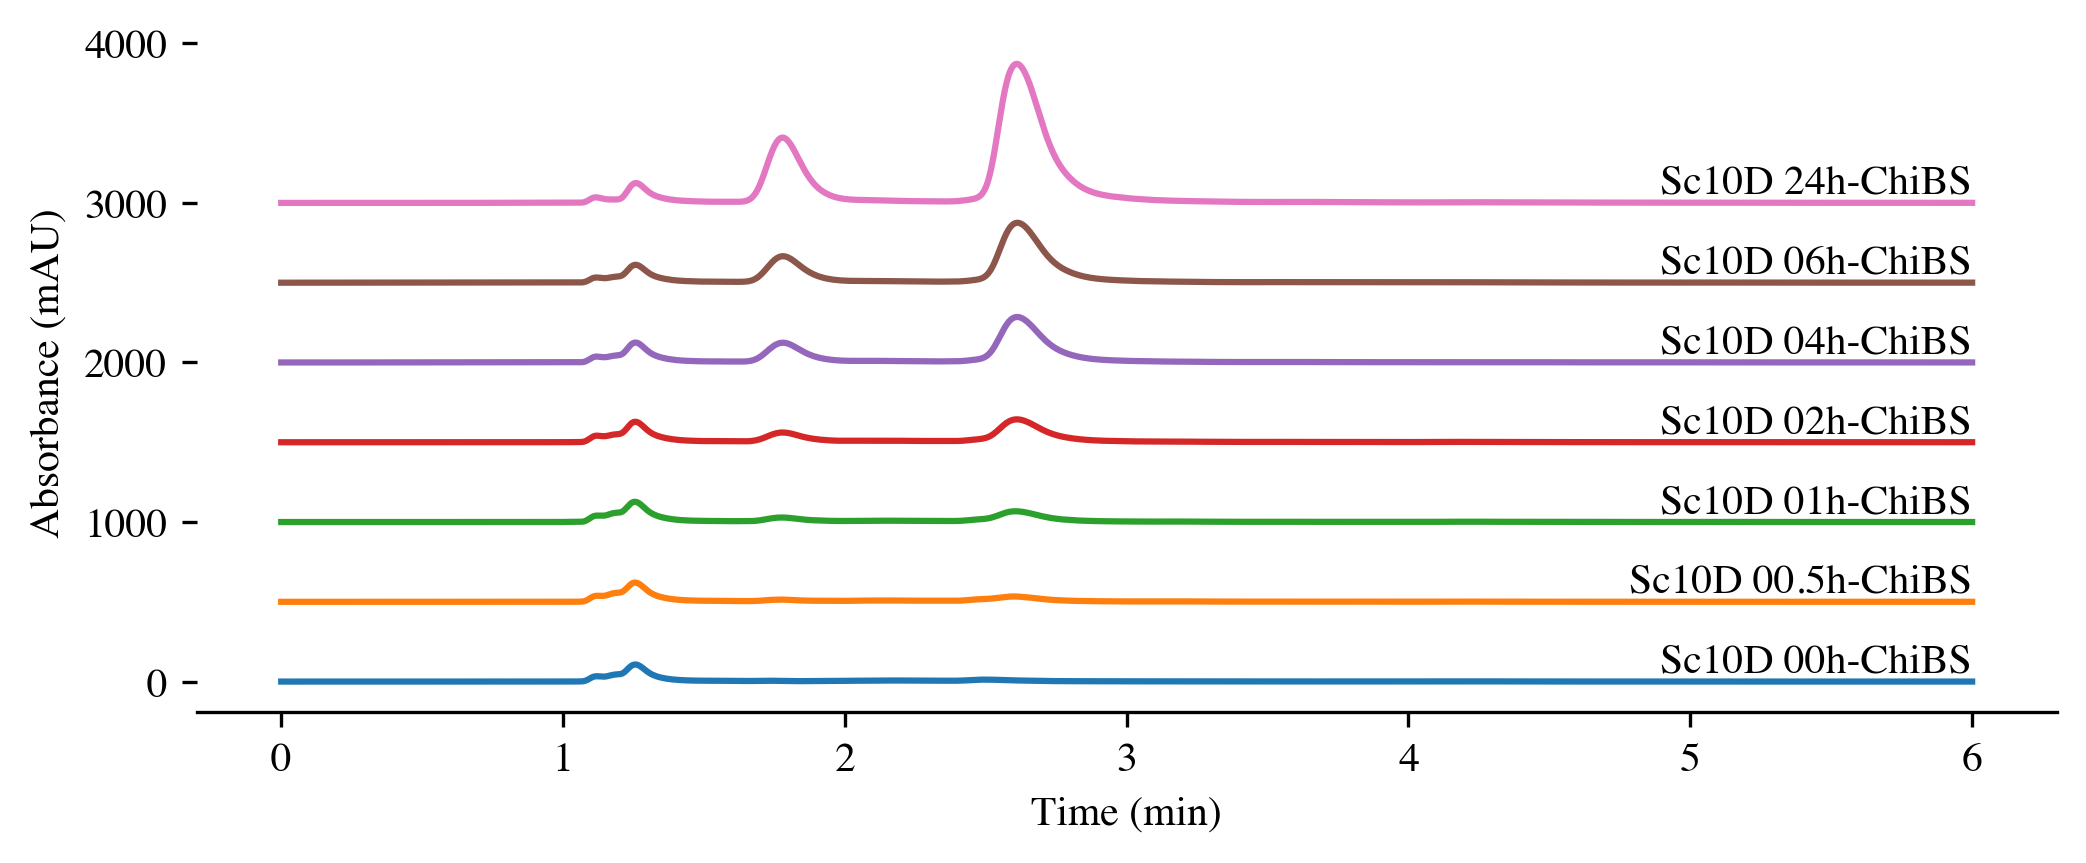

In [ ]:
cols = [c for c in df_rz if 'ChiBS_1' in c and 'Sc10' in c]
cols = [
    'Sc10D_00h-ChiBS_1',
    'Sc10D_00.5h-ChiBS_1',
    'Sc10D_01h-ChiBS_1',
    'Sc10D_02h-ChiBS_1',
    'Sc10D_04h-ChiBS_1',
    'Sc10D_06h-ChiBS_1',
    'Sc10D_24h-ChiBS_1']
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=500, shiftx=0, name_len=2,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',color = colors,
                    no_negatives=False)

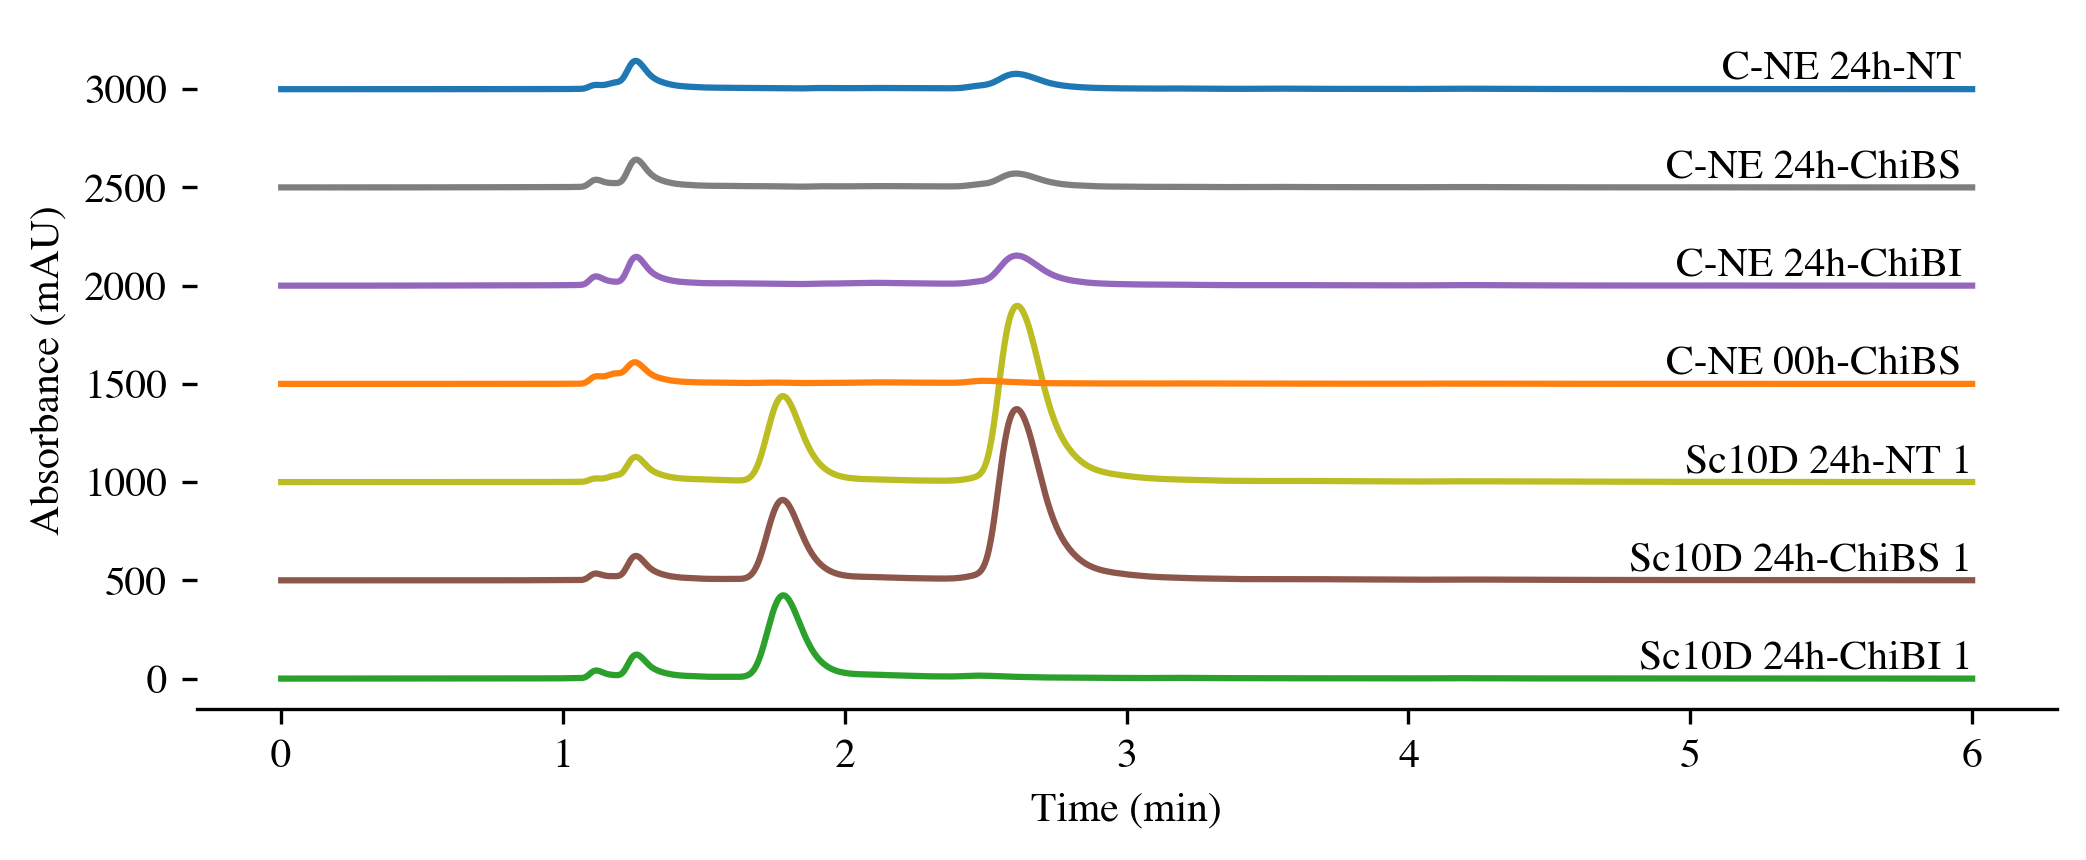

In [ ]:
cols = [c for c in df_rz if 'Sc10D' in c and '24' in c and '_1' in c] + [c for c in df_rz if 'NE' in c]

ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=500, shiftx=0, name_len=3,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False, )

In [ ]:
cols = [
#     u'Std_A2ox-800µM_10',
#     'Std_A2ox-100µM_07',
#      'Std_A2ox-50µM_06',
'Std_A2ox-10µM_04',
'C-NE_24h-NT_',
# '4_24h-NT_1',
#  '4_24h-NT_2',
#  '4_24h-NT_3',
# '4_24h-NT_NA',
'7_24h-NT_1',
 '7_24h-NT_2',
 '7_24h-NT_3',
 '7_24h-NT_NA',
#  'Sc10D_24h-ChiBS_1',
#      'Sc10D_24h-NT_1',
#  'Sc10D_24h-NT_2',
#  'Sc10D_24h-NT_3',
#  'Sc10D_24h-NT_NA',
]

In [ ]:
cols = [
#     'Sc10D_24h-ChiBS_1',
#  'Sc10D_06h-ChiBS_1',
#  'Sc10D_04h-ChiBS_1',
#  'Sc10D_02h-ChiBS_1',
 'Sc10D_01h-ChiBS_1',
 'Sc10D_00.5h-ChiBS_1',
 'Sc10D_00h-ChiBS_1']

In [ ]:
cols = [c for c in df_rz if 'Sc10D' in c]

In [ ]:
df_rz

time  4_00.5h-ChiBS_1  4_00.5h-ChiBS_2  4_00.5h-ChiBS_3  \
0     0.0000        -0.053158        -0.013200        -0.020542   
1     0.0017        -0.095302        -0.047054        -0.053504   
2     0.0033        -0.034402        -0.036423        -0.020797   
3     0.0050        -0.047055        -0.034664        -0.002124   
4     0.0067        -0.044345        -0.016598        -0.033700   
...      ...              ...              ...              ...   
3596  5.9933         0.043151         0.052005         0.003935   
3597  5.9950         0.016822         0.061936         0.050385   
3598  5.9967         0.078526         0.066574         0.005963   
3599  5.9983         0.045884         0.021582         0.053757   
3600  6.0000         0.049270         0.010004         0.000646   

      4_00h-ChiBS_1  4_00h-ChiBS_2  4_00h-ChiBS_3  4_00h-ChiBS_NA  \
0         -0.051451      -0.048819      -0.042612       -0.029342   
1         -0.070525      -0.074292      -0.079619       -0.065539   
2         -0.062849      -0.064553      -0.064705       -0.048639   
3         -0.055716      -0.056458      -0.045993       -0.081228   
4         -0.046779      -0.071770      -0.075393       -0.029731   
...             ...            ...            ...             ...   
3596       0.058884       0.017441      -0.042687       -0.038897   
3597       0.045013      -0.029569      -0.072773       -0.041119   
3598       0.095110       0.017756      -0.094178       -0.007866   
3599       0.106010       0.016255      -0.074279       -0.007295   
3600       0.075879       0.001789      -0.048504       -0.036225   

      4_01h-ChiBS_1  4_01h-ChiBS_2  ...  Std_A2ox-25µM_56  Std_A2ox-400µM_09  \
0          0.004005      -0.065564  ...         -0.086651          -0.059947   
1         -0.039420      -0.041741  ...         -0.067425          -0.030014   
2         -0.022337      -0.103244  ...         -0.078269          -0.063454   
3         -0.035164      -0.098460  ...         -0.038532          -0.055415   
4         -0.040836      -0.056026  ...         -0.077128          -0.088484   
...             ...            ...  ...               ...                ...   
3596       0.115375      -0.075056  ...         -0.226971           0.278531   
3597       0.139155      -0.013278  ...         -0.248757           0.274969   
3598       0.093682      -0.018169  ...         -0.207037           0.255651   
3599       0.130228      -0.051307  ...         -0.286822           0.263077   
3600       0.070535      -0.011638  ...         -0.216364           0.261627   

      Std_A2ox-400µM_131  Std_A2ox-400µM_60  Std_A2ox-50µM_06  \
0              -0.043368          -0.039769         -0.124013   
1              -0.061829          -0.041987         -0.027506   
2              -0.095525          -0.032926         -0.055711   
3              -0.067151          -0.037565         -0.012636   
4              -0.061786          -0.100959         -0.004958   
...                  ...                ...               ...   
3596            0.060094           0.221197          0.375998   
3597            0.059043           0.231378          0.372918   
3598            0.056598           0.268918          0.386388   
3599            0.088821           0.251849          0.377131   
3600            0.020570           0.236946          0.400347   

      Std_A2ox-50µM_128  Std_A2ox-50µM_57  Std_A2ox-800µM_10  \
0             -0.109754         -0.043205          -0.001744   
1             -0.109514         -0.010535          -0.032152   
2             -0.100949         -0.032019          -0.024251   
3             -0.097509         -0.074296          -0.070993   
4             -0.091918         -0.055475          -0.004335   
...                 ...               ...                ...   
3596           0.058407          0.023991           0.268061   
3597           0.067548          0.023108           0.315949   
3598           0.071398          0.081903           0.30

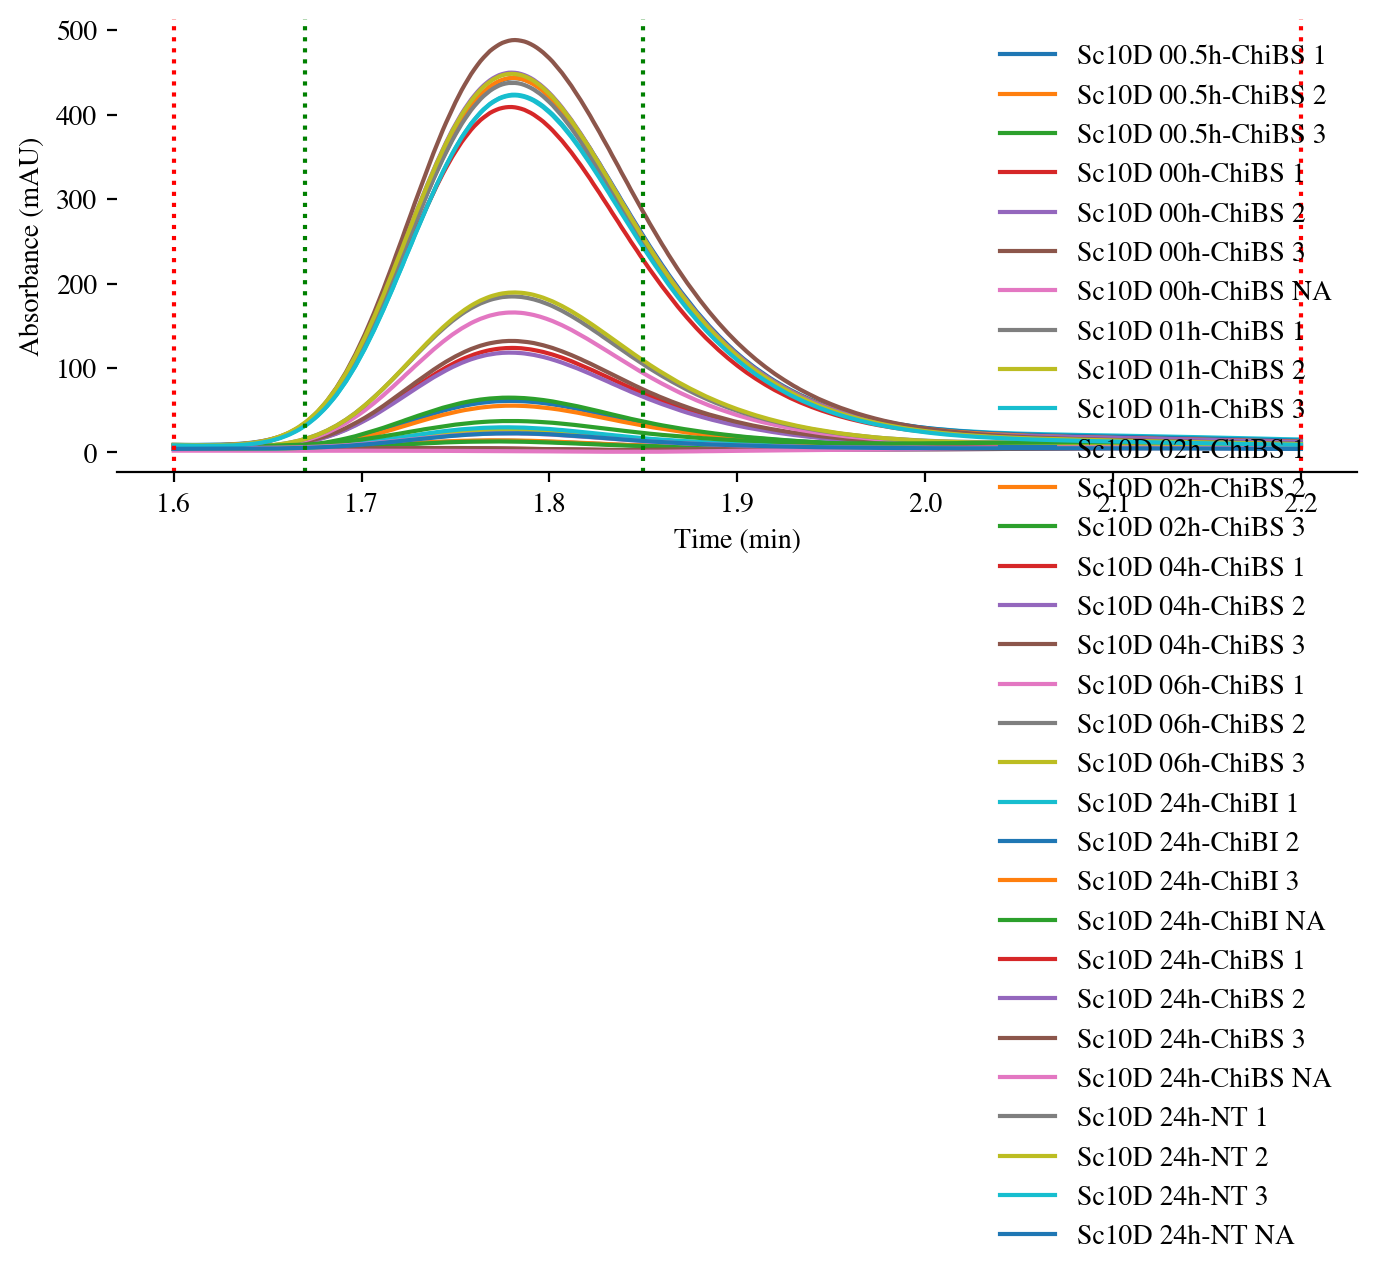

In [ ]:

ax = plot_ics_chrom(df_rz.set_index('time'), cols, x_min=1.6, x_max=2.2, y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=0, shiftx=0, name_len=3,
                    figsize=(8,3), dpi=200,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False)
for x in [1.6, 2.2]:
    ax.axvline(x, linestyle=':', color='r')
for x in [1.67, 1.85]:
    ax.axvline(x, linestyle=':', color='g')

## AEC chromatograms

### AEC protein 4

In [ ]:
df_aec_4 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220607_4C1.csv')

In [ ]:
df_fracs_aec_4 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_4_AEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

In [ ]:
# df_aec_4.describe()

In [ ]:
df_fracs_aec_4.head()

no   start     end
0   1  223.64  225.63
1   2  225.63  227.62
2   3  227.62  229.62
3   4  229.62  231.62
4   5  231.62  233.62

Text(0.5, 0.01, 'Volume (mL)')

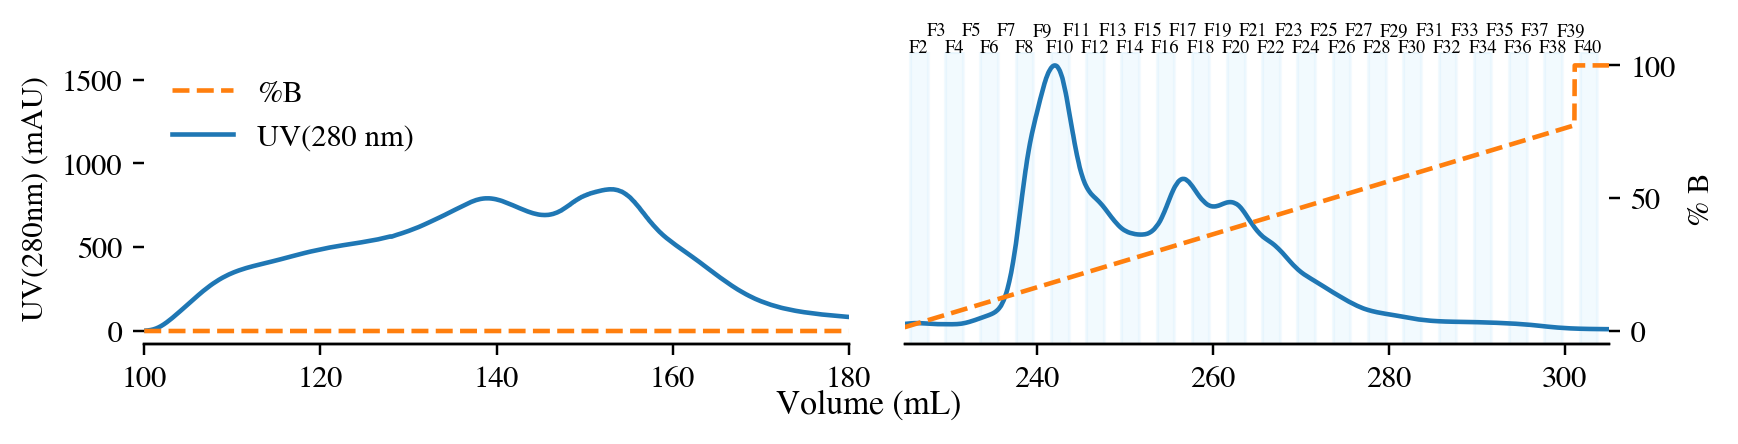

In [ ]:
vrs = [
    'UV(280 nm)',
    '%B',
#     'Flow Rate',
#    'System Pressure',
#    'Conductivity'
]

band_colors = ['lightskyblue', (1,1,1)]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,2), dpi=220)
n = 0
for ax in axs:
    h, l = [], []
    
    # Plot fraction bands
    df_fracs_aec_4.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)
    
    # Plot flow
    v = '%B'
    x, y = [c for c in df_aec_4 if v in c]
    color = sns.color_palette('tab10')[1]
    nax = sns.lineplot(x=df_aec_4.loc[df_aec_4[x]>90, x], y=df_aec_4.loc[df_aec_4[x]>90, y], label=v, color=color, ax=ax.twinx(), linestyle='--')
    hi, li = nax.get_legend_handles_labels()
    nax.legend().remove()
    h += hi
    l += li


    # Plot UV
    v = 'UV(280 nm)'
    x, y = [c for c in df_aec_4 if v in c]
    color = sns.color_palette('tab10')[0]
    sns.lineplot(x=df_aec_4.loc[df_aec_4[x]>90, x], y=df_aec_4.loc[df_aec_4[x]>90, y], label=v, color=color, ax=ax)
    hi, li = ax.get_legend_handles_labels()
    h += hi
    l += li
    ax.legend().remove()
    ax.set_xlabel('')

    
    sns.despine(left=True)
    if n == 0:
        ax.set_xlim(100, 180)
        ax.set_ylabel('UV(280nm) (mAU)')
        nax.set_ylabel('')
        nax.set_yticks([])
    else:
        ax.set_xlim(225, 305)
        ax.tick_params(axis='y', length=0)
        df_fracs_aec_4[(df_fracs_aec_4.end < 305) & (df_fracs_aec_4.start > 225)].apply(
            lambda x: nax.text(np.average((x.start, x.end)), 110,
                              'F{}'.format(int(x.no)), fontsize=6,
                              ha='center', va=['top','bottom'][int(x.no%2)]
                             ), axis=1)
        nax.set_ylabel('% B')
#         nax.set_ylim(-10,120)
#         ax.set_ylim(-1600,1900)
    n +=1

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)

### AEC protein 7

In [ ]:
df_aec_7 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220607_7C3.csv')

In [ ]:
df_fracs_aec_7 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_7_AEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

In [ ]:
plt.subplots?

In [ ]:
gridspec.GridSpec?

Text(0.5, 0.01, 'Volume (mL)')

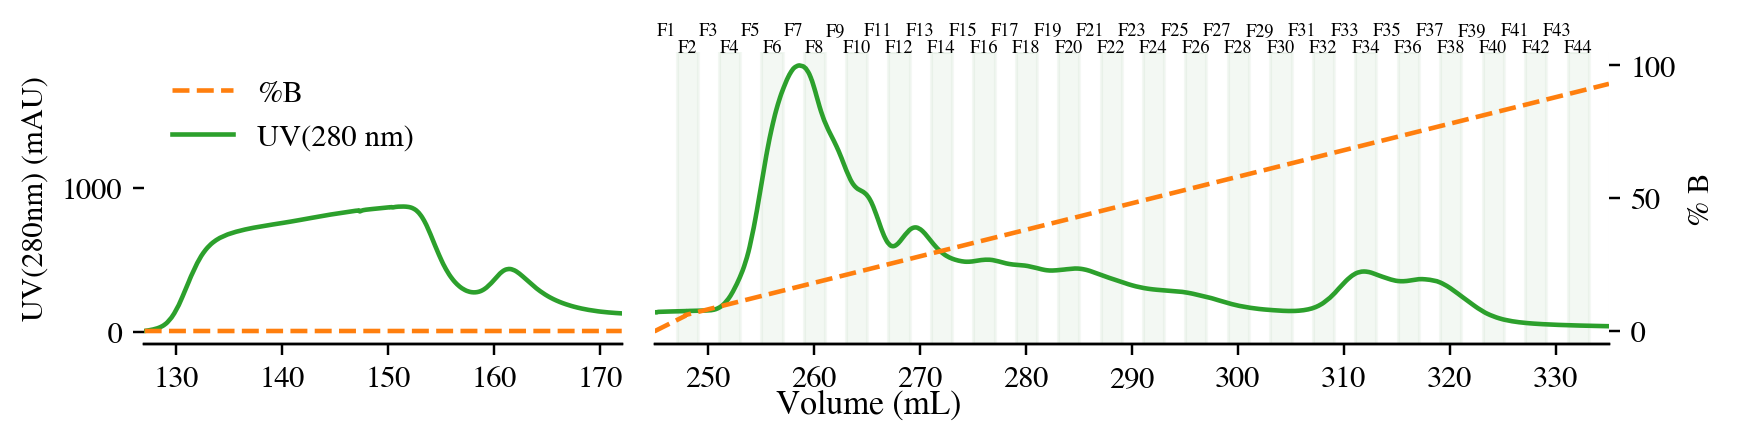

In [ ]:
band_colors = ['darkseagreen', (1,1,1)]
span = 80
x_min1 = 127
x_min2 = 245
x_max1 = x_min1 + 45
x_max2 = x_min2 + 90
fig, axs = plt.subplots(
    1, 2, sharey=True,
    figsize=(8,2), dpi=220,
    gridspec_kw={'width_ratios':[1,2]})

color_UV = sns.color_palette('tab10')[2]
color_B = sns.color_palette('tab10')[1]
# gs = gridspec.GridSpec(1, 3)

# ax0 = plt.subplot(gs[0,0])
# ax1 = plt.subplot(gs[0,1:3])
# axs = (ax0, ax1)
n = 0
for ax in axs:
    h, l = [], []
    
    # Plot fraction bands
    df_fracs_aec_7.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)
    
    # Plot B
    v = '%B'
    x, y = [c for c in df_aec_7 if v in c]
    nax = sns.lineplot(x=df_aec_7.loc[df_aec_7[x]>x_min1, x], y=df_aec_7.loc[df_aec_7[x]>x_min1, y], label=v, color=color_B, ax=ax.twinx(), linestyle='--')
    hi, li = nax.get_legend_handles_labels()
    nax.legend().remove()
    h += hi
    l += li


    # Plot UV
    v = 'UV(280 nm)'
    x, y = [c for c in df_aec_7 if v in c]
    sns.lineplot(x=df_aec_7.loc[df_aec_7[x]>x_min1, x], y=df_aec_7.loc[df_aec_7[x]>x_min1, y], label=v, color=color_UV, ax=ax)
    hi, li = ax.get_legend_handles_labels()
    h += hi
    l += li
    ax.legend().remove()
    ax.set_xlabel('')

    
    sns.despine(left=True)
    if n == 0:
        ax.set_xlim(x_min1, x_max1)
        ax.set_ylabel('UV(280nm) (mAU)')
        nax.set_ylabel('')
        nax.set_yticks([])
    else:
        ax.set_xlim(x_min2, x_max2)
        ax.tick_params(axis='y', length=0)
        df_fracs_aec_7[(df_fracs_aec_7.end < x_max2) & (df_fracs_aec_7.start > x_min2)].apply(
            lambda x: nax.text(np.average((x.start, x.end)), 110,
                              'F{}'.format(int(x.no)), fontsize=6,
                              ha='center', va=['top','bottom'][int(x.no%2)]
                             ), axis=1)
        nax.set_ylabel('% B')
#         nax.set_ylim(-10,120)
#         ax.set_ylim(-1600,1900)
    n +=1

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)

## SEC chromatogram

In [ ]:
df_sec_4 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220608_4C1_SEC.csv', skiprows=1)

In [ ]:
df_fracs_sec_4 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_4_SEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

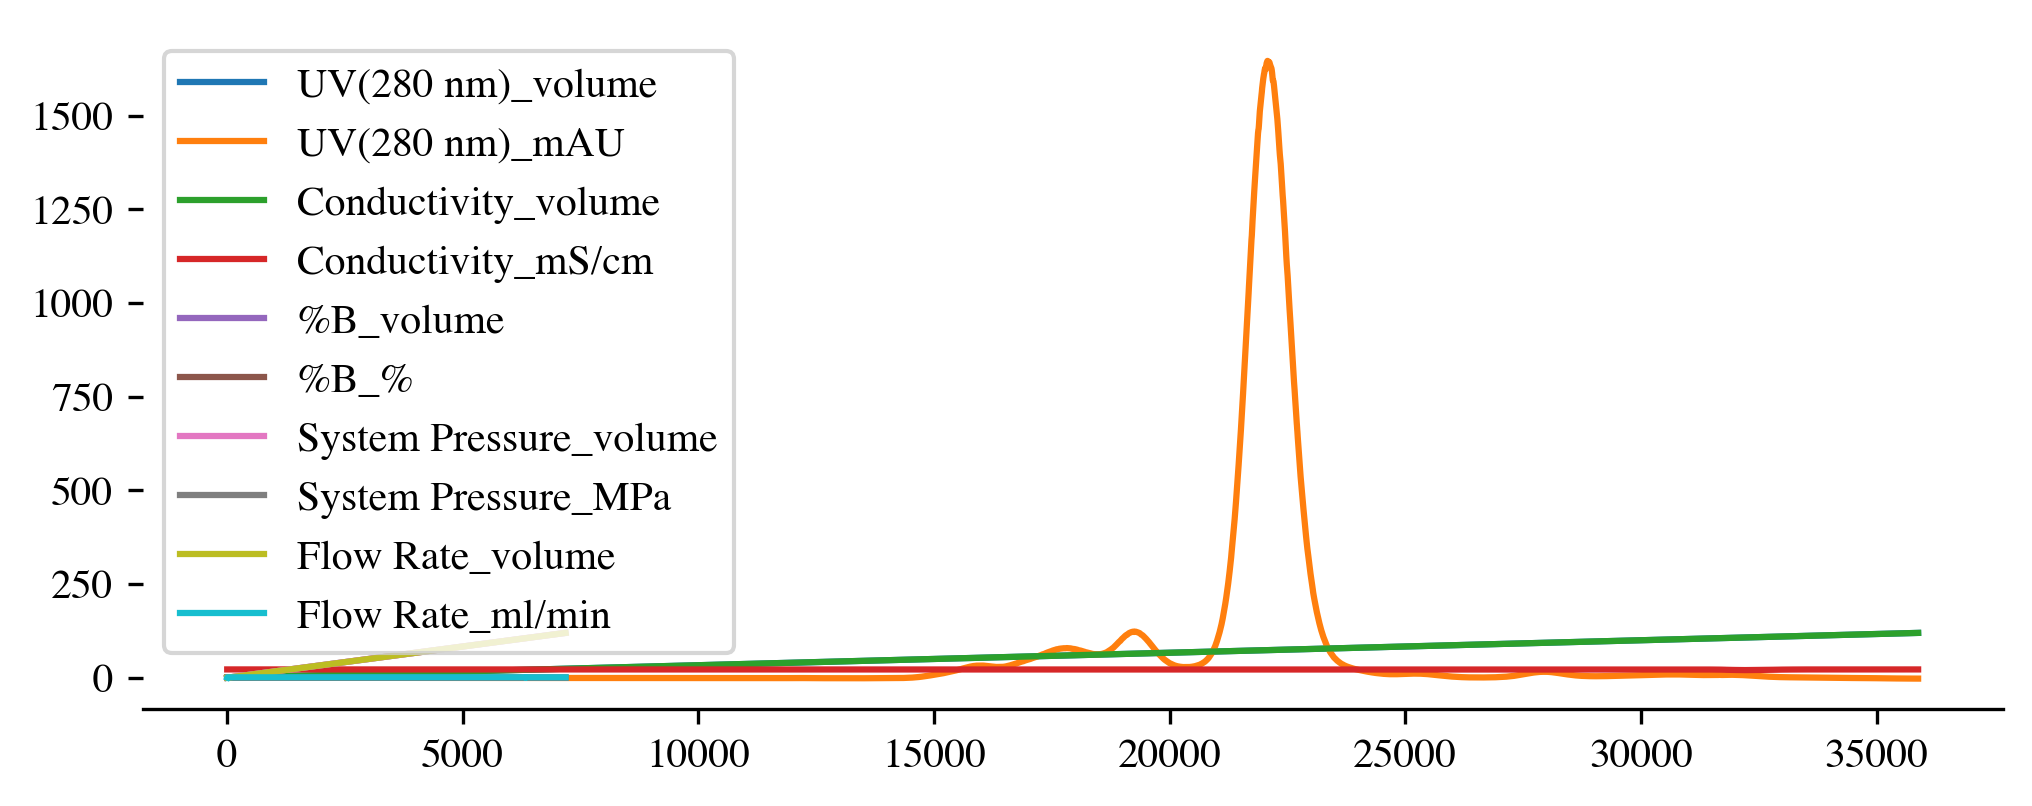

In [ ]:
# plt.figure(figsize=(10,2), dpi=300)
df_sec.plot(figsize=(8,3))
fig = plt.gcf()
fig.set_dpi(300)
sns.despine(left=True)

In [ ]:
list(set([c.split('_')[0] for c in df_sec]))

['%B', 'UV(280 nm)', 'Flow Rate', 'System Pressure', 'Conductivity']

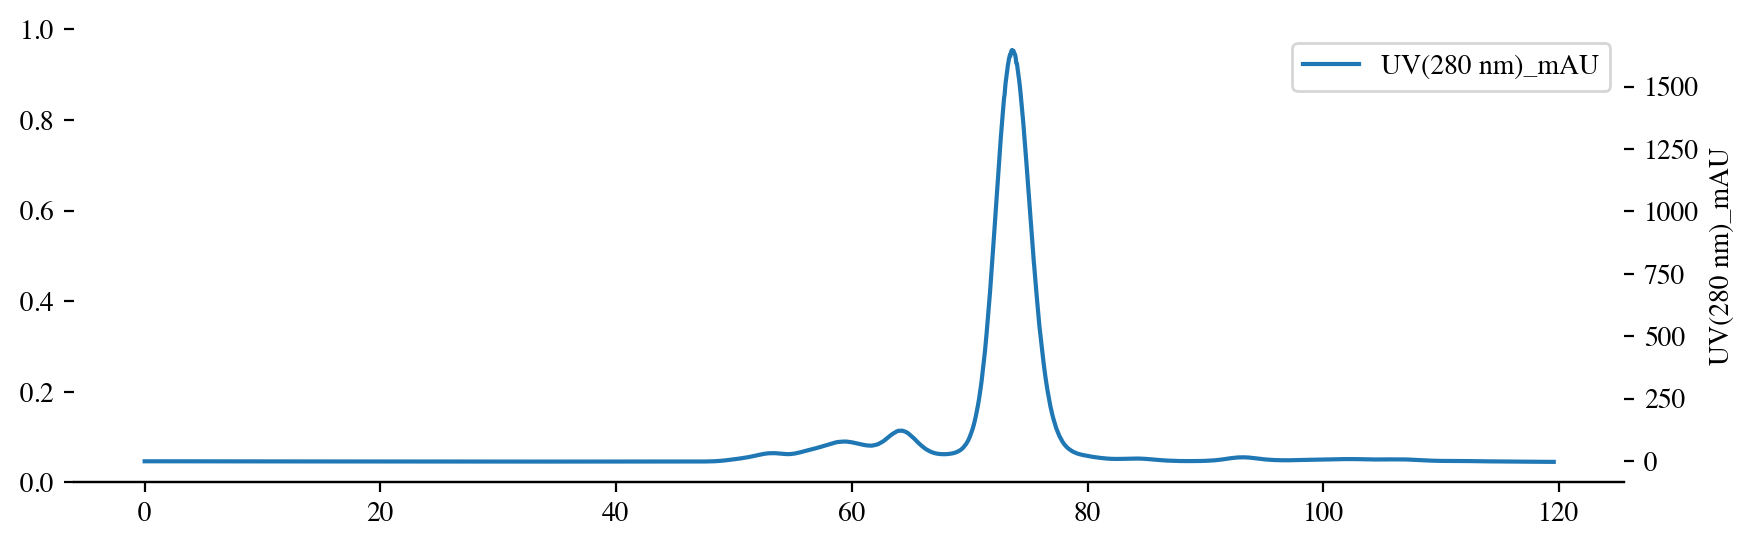

In [ ]:
vrs = [
#    '%B',
    'UV(280 nm)',
#    'Flow Rate',
#    'System Pressure',
#    'Conductivity'
]
plt.figure(figsize=(10,3), dpi=200)
ax = plt.axes()
for v in vrs:
    nax = ax.twinx()
    x, y = [c for c in df_sec_4 if v in c]
    sns.lineplot(x=df_sec_4[x], y=df_sec_4[y], label=y, ax=nax)
sns.despine(left=True)

In [ ]:
df_sec_4

UV(280 nm)_volume  UV(280 nm)_mAU  Conductivity_volume  \
0               0.000250       -0.167650             0.000250   
1               0.001833       -0.167450             0.001833   
2               0.004250       -0.167249             0.004250   
3               0.005917       -0.167048             0.005917   
4               0.007500       -0.166746             0.007500   
...                  ...             ...                  ...   
35877         119.543236       -2.429941           119.543236   
35878         119.546570       -2.430732           119.546570   
35879         119.549904       -2.431741           119.549904   
35880         119.549904       -2.432749           119.549904   
35881         119.549904       -2.434152           119.549904   

       Conductivity_mS/cm  %B_volume  %B_%  System Pressure_volume  \
0               22.066490   0.000000   0.0                0.005917   
1               22.066490   0.003250   0.0                0.020833   
2               22.066490   0.015833   0.0                0.037500   
3               22.065371   0.032500   0.0                0.054167   
4               22.101574   0.049167   0.0                0.070833   
...                   ...        ...   ...                     ...   
35877           22.072159        NaN   NaN                     NaN   
35878           22.072159        NaN   NaN                     NaN   
35879           22.036562        NaN   NaN                     NaN   
35880           22.036562        NaN   NaN                     NaN   
35881           22.036562        NaN   NaN                     NaN   

       System Pressure_MPa  Flow Rate_volume  Flow Rate_ml/min  
0                -0.034474          0.000000               0.0  
1                -0.034474          0.000000               1.0  
2                -0.020684          0.003250               1.0  
3                 0.020684          0.015833               1.0  
4                 0.068948          0.032500               1.0  
...                    ...               ...               ...  
35877                  NaN               NaN               NaN  
35878                  NaN               NaN               NaN  
35879                  NaN               NaN               NaN  
35880                  NaN               NaN               NaN  
35881                  NaN               NaN               NaN  

[35882 rows x 10 columns]

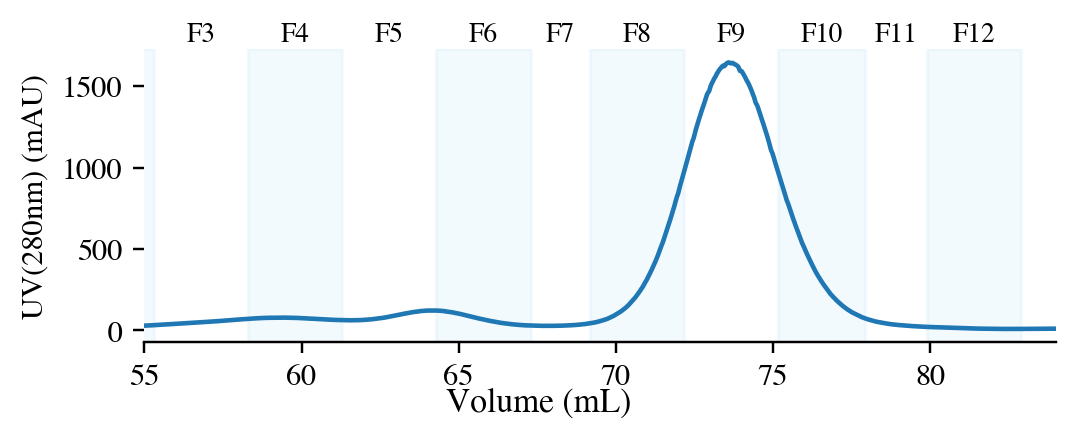

In [ ]:
band_colors = ['lightskyblue', (1,1,1)]
x_min, x_max = (55, 84)
fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=220)

## Plot fraction bands
df_fracs_sec_4.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)

# # Plot flow
# v = '%B'
# x, y = [c for c in df_sec_4 if v in c]
# color = sns.color_palette('tab10')[1]
# nax = sns.lineplot(x=df_sec_4.loc[df_sec_4[x]>90, x], y=df_sec_4.loc[df_sec_4[x]>90, y], label=v, color=color, ax=ax.twinx(), linestyle='--')
# hi, li = nax.get_legend_handles_labels()
# nax.legend().remove()
# h += hi
# l += li


# Plot UV
v = 'UV(280 nm)'
x, y = [c for c in df_sec_4 if v in c]
sub_df = df_sec_4[df_sec_4[x].between(x_min, x_max)]
color = sns.color_palette('tab10')[0]
sns.lineplot(x=sub_df[x], y=sub_df[y], label=v, color=color, ax=ax)
hi, li = ax.get_legend_handles_labels()
h += hi
l += li
ax.legend().remove()
ax.set_xlabel('')


# sns.despine(left=True)
# if n == 0:
#     ax.set_xlim(100, 180)
ax.set_ylabel('UV(280nm) (mAU)')
#     nax.set_ylabel('')
#     nax.set_yticks([])
# else:
ax.set_xlim(x_min, x_max)
#     ax.tick_params(axis='y', length=0)
df_fracs_sec_4[(df_fracs_sec_4.start>x_min) & (df_fracs_sec_4.end<x_max)].apply(
    lambda x: ax.text(np.average((x.start, x.end)), 1900,
                      'F{}'.format(int(x.no)), fontsize=9,
                      ha='center', va='top'
                     ), axis=1)

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)
sns.despine(left=True)